In [1]:
# The main data set contains information about the time spent learning foreign languages each day 
# from March 2019 to November 2022;
# Our goal is to identify days with no learning
# For additional features, we have to assemble information from other sources(excel files in this case)
# we will also create some binomial features based on our knowledge and perform feature engineering
# to create new features from date columns
# then we will drop the date for model training to reframe this time series problem as a supervised learning problem;

# First importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ignore warnings in order to make code more easy to read on github
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\github\classification_project\ML_projects_on_own_language_learning_dataset\yt_cleaned_110319_071122.xlsx')

# In case of this dataset blank cell means 0;

df = df.fillna(0)
df.index=df.date
df['sum'] = df.sum(numeric_only=True, axis=1)

# joining data from another file with average time of online course videos watched on linked_in learning;
# filling null values with mean or 0 depending on date column
# the second file starts in 2021 while main df samples start from 2019, thus we need to fill in na values again

df = df['sum'].reset_index()
linked_in_learning_df = pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\linked_in_learning.xlsx')
df = pd.merge(df,linked_in_learning_df,on='date',how='left')


mean_course = df['avg_course_day'].mean()

df['avg_course_day'] = np.where((pd.isnull(df['avg_course_day']))&(df['date']>=pd.to_datetime('08-01-2021')),mean_course,
                               np.where((pd.isnull(df['avg_course_day'])) & (df['date']<pd.to_datetime('08-01-2021')),0
                                       ,df['avg_course_day']))

# joining data from yet another file containing the amount of working hours

working_hours_df = pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\github\classification_project\ML_projects_on_own_language_learning_dataset\work_hours.xlsx')
df = pd.merge(df,working_hours_df,on='date',how='left')
df.fillna(0, inplace = True)


# joining data from another file with average activity; the column shows a mean number of steps walked each month since April 2021;
# second file starts in 2021 while main df samples start from 2019, thus we need to fill in na values again
# we decide to fill the missing values values for working days with the distance between home and work place,
# for other place 1/3 of that distance  

steps = pd.read_excel(r'C:\Users\Olga\Desktop\linkedinlearning\Python\notebooks\github\classification_project\ML_projects_on_own_language_learning_dataset\steps.xlsx')
df = pd.merge(df,steps,on='date',how='left')
df['mean_steps'] = np.where((df['work_hours']!=0) & (df['date']<pd.to_datetime('12-01-2019')) & (df['date']>pd.to_datetime('06-01-2019')),2000, df['mean_steps'])
df['mean_steps'] = df['mean_steps'].fillna(600)

# reseting index to be able to use date column
df = df.reset_index().drop(['index'], axis = 1)

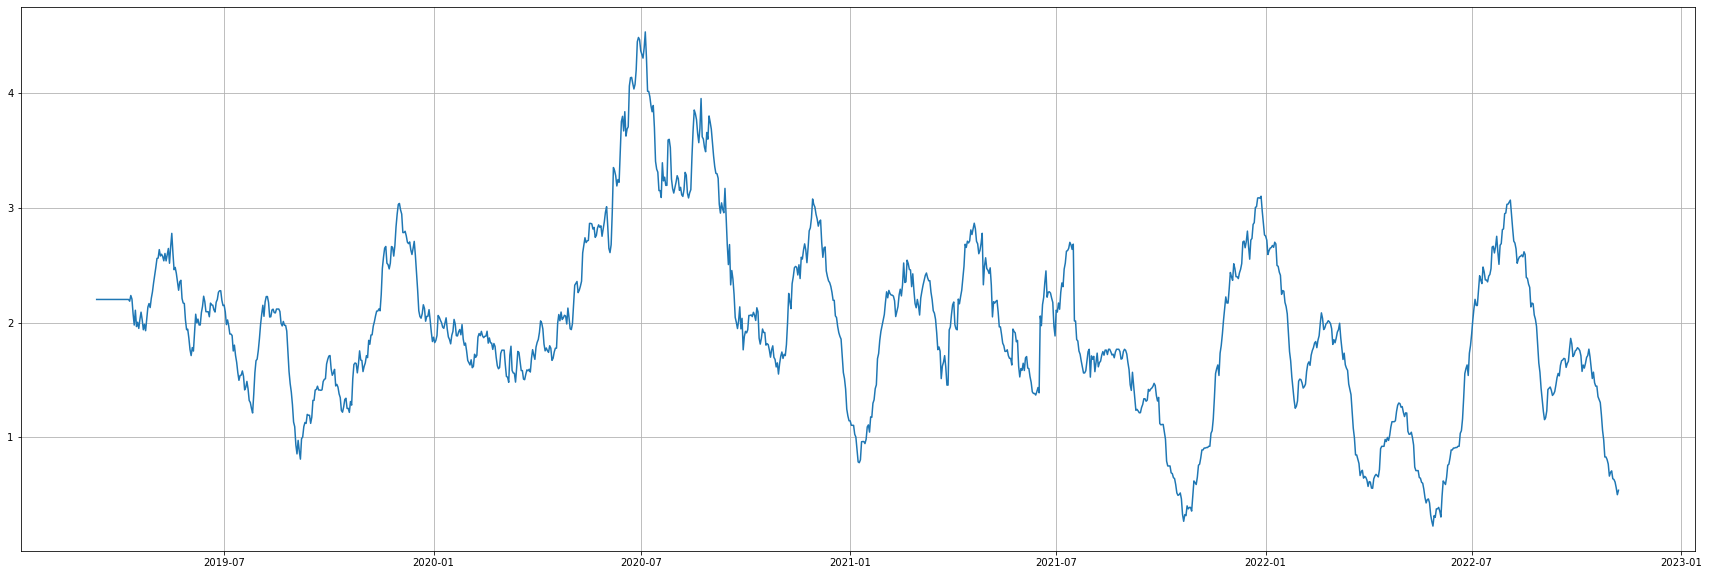

In [3]:
# Our dataset is a timeseries, but as we have features(and will create new ones) that are not time dependent,
# we will frame our problem as supervised learning classification
# calculating moving average for the sum column to see overall and seasonal trends more clearly

import datetime as dt

df['rolling30'] = df['sum'].rolling(30).mean()
df = df.fillna(np.mean(df['sum'][0:29]))
dates = df['date'][df['date'].dt.day==11].reset_index(drop=True)
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(df['date'], df['rolling30'])
plt.grid(True)

# We see biggest peaks in summer and smaller peaks in winter
# the general trend seems to be slightly decreasing

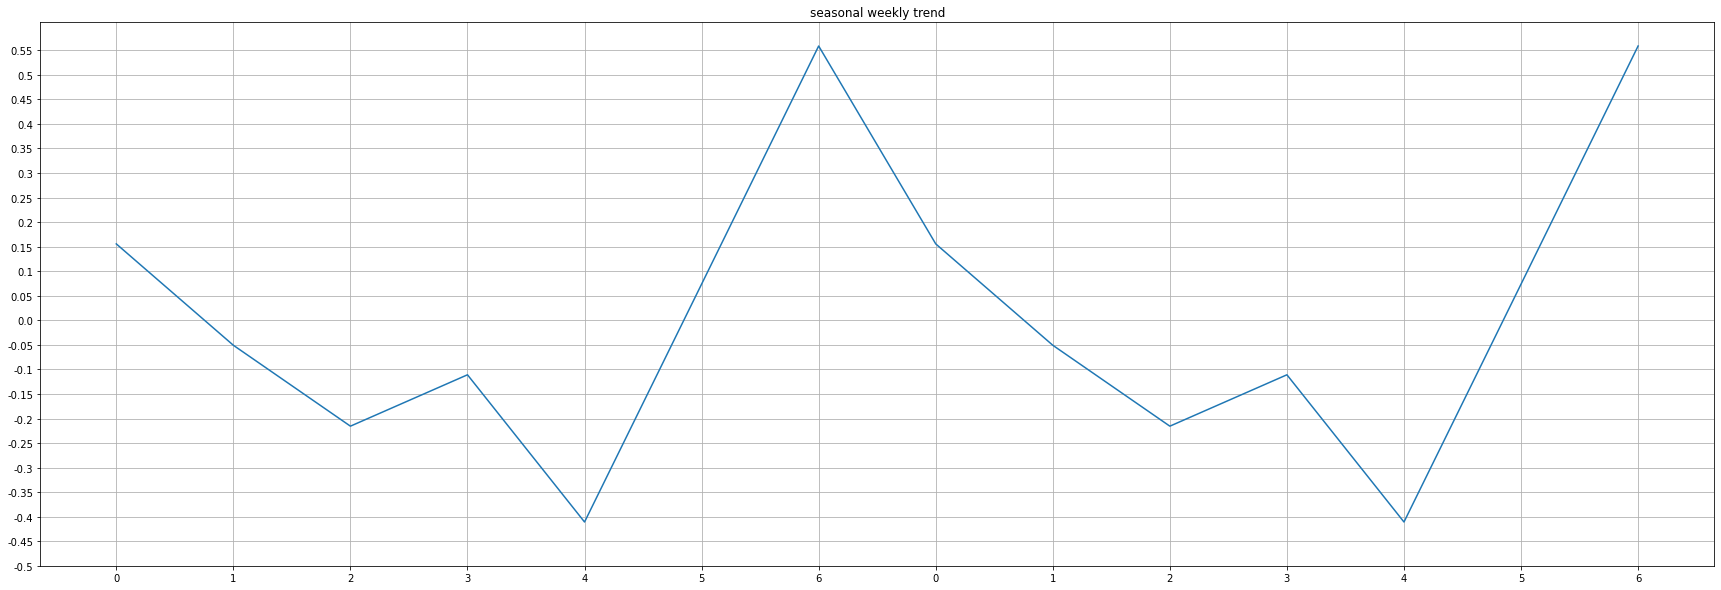

In [4]:
# Time series decomposition, to do a more profound check for seasonal and general trend and for residual component;

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['sum'], model='additive',period=7)
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(df['date'][14:28],result.seasonal[14:28])
plt.xticks(df['date'][14:28],df['date'][14:28].dt.weekday)
plt.yticks([i/100 for i in range(-50,60,5)],[i/100 for i in range(-50,60,5)] )
plt.grid(True)
plt.title('seasonal weekly trend')

# the weekly trend seems to be: most learning on Sunday, then decreasing during the week and again increasing on Saturday; 
# The most differences are seen between weekend and week

# We are adding sine and cosine transformation of day of the week as another features

df['weekday_sin'] = np.sin(2 * np.pi * (df['date'].dt.weekday)/7)
df['weekday_cos'] = np.cos(2 * np.pi * (df['date'].dt.weekday)/7)

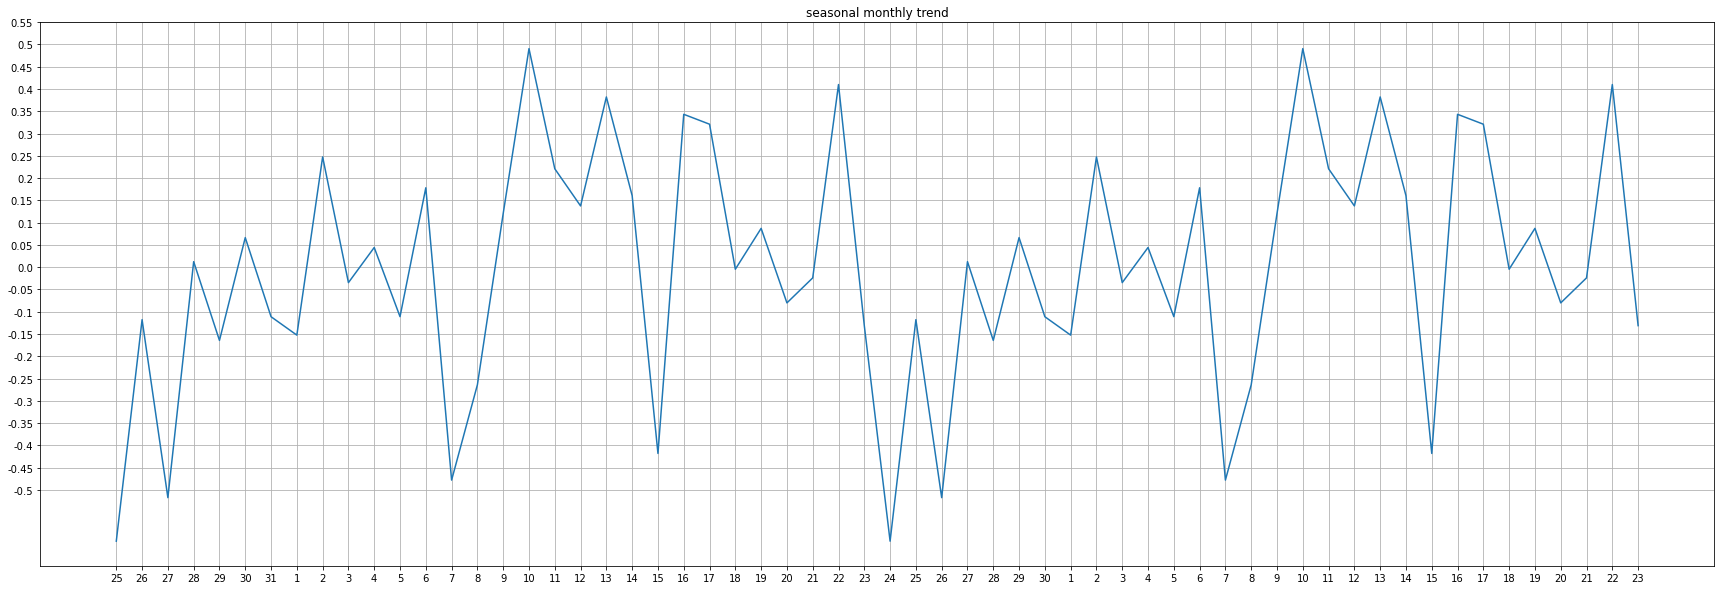

In [5]:
# Time series decomposition, to do a more profound check for seasonal and general trend and for residual component;

result = seasonal_decompose(df['sum'], model='additive',period=30)
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(df['date'][14:74],result.seasonal[14:74])
plt.xticks(df['date'][14:74],df['date'][14:74].dt.day)
plt.yticks([i/100 for i in range(-50,60,5)],[i/100 for i in range(-50,60,5)] )
plt.grid(True)
plt.title('seasonal monthly trend')

# the monthly trend seems to be: most learning beetween 9 and 14th of the month, decrease at the end of the month 
# and then again increase 

# we will divide each month in 3 parts, make it a feature and create dummy variables for the column 

df['part_of_month'] = np.where(df['date'].dt.day<=10,1,np.where((df['date'].dt.day>10) & (df['date'].dt.day<=20),2, 3 ))
df = pd.get_dummies(df, columns=['part_of_month'], drop_first = True) 

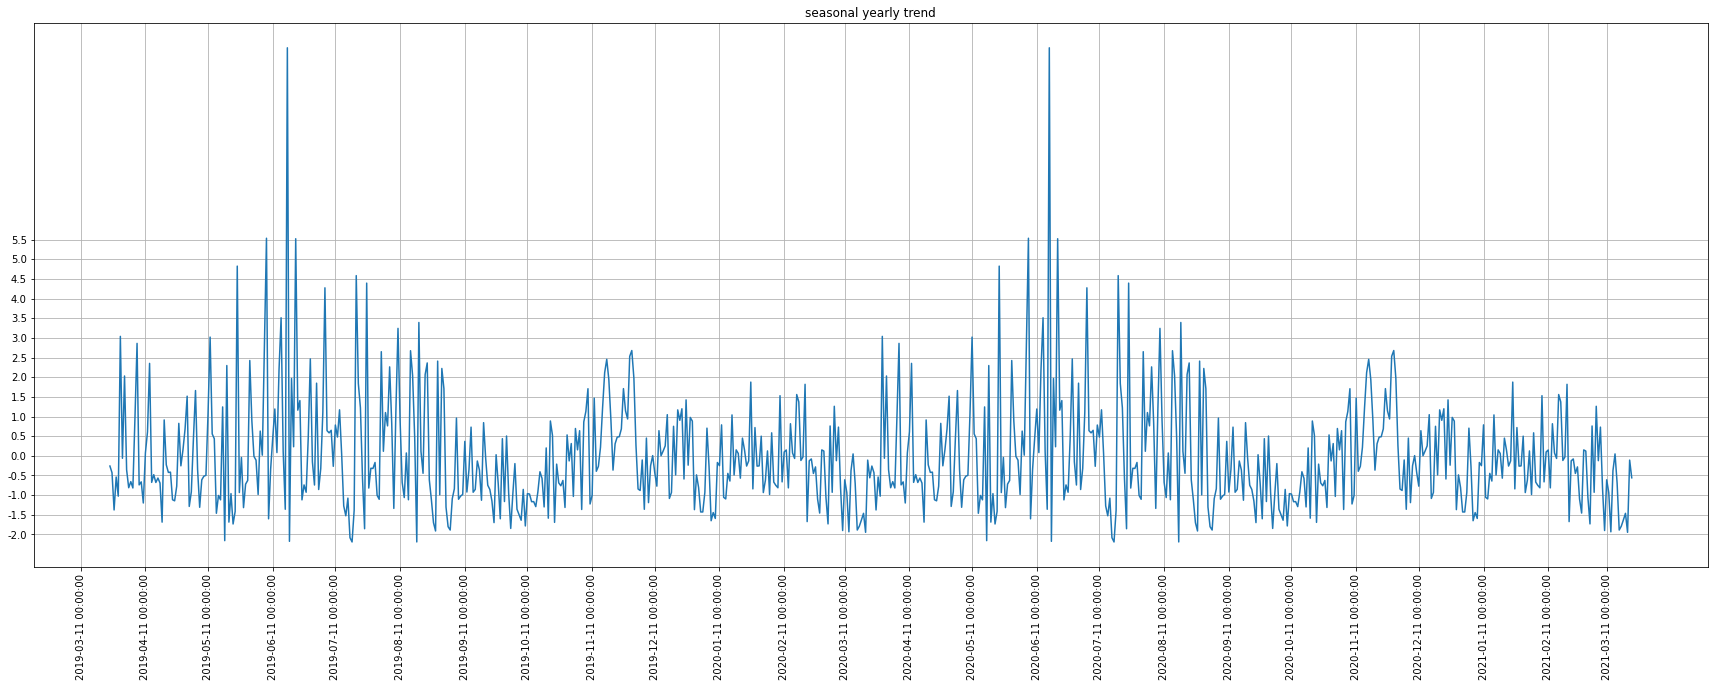

In [6]:
# Time series decomposition, to do a more profound check for seasonal and general trend and for residual component;

result = seasonal_decompose(df['sum'], model='additive',period=365)
plt.rcParams["figure.figsize"] = (30,10)
# plt.plot(df['date'],result.observed.values)
plt.plot(df['date'][14:744],result.seasonal[14:744])
plt.xticks(dates[0:25],dates[0:25], rotation='vertical')
plt.yticks([i/100 for i in range(-200,600,50)],[i/100 for i in range(-200,600,50)] )
plt.grid(True)
plt.title('seasonal yearly trend')

# the yearly trend seems to be: most learning in summer, then decreasing, small peak late autumn and early winter,
# low values in the winter and increasing to again peak in summer 
# Our models performs better having time features encoded as sine/cosine transformations than dummy variables
# We will create a lot of additional features - both categorical 0-1 dummy variables
# for month and quarter and sine/cosine transformations; o

df['q_sin'] = np.sin(2 * np.pi * (df['date'].dt.quarter)/4)
df['q_cos'] = np.cos(2 * np.pi * (df['date'].dt.quarter)/4)

df['month_sin'] = np.sin(2 * np.pi * (df['date'].dt.month)/12)
df['month_cos'] = np.cos(2 * np.pi * (df['date'].dt.month)/12)

df['wok_sin'] = np.sin(2 * np.pi * (df['date'].dt.isocalendar().week)/52)
df['wok_cos'] = np.cos(2 * np.pi * (df['date'].dt.isocalendar().week)/52)


The IQR is 2.7
The lower boundary is -3.750000000000001
The upper boundaryis 7.050000000000001
Total number of outliers are 35


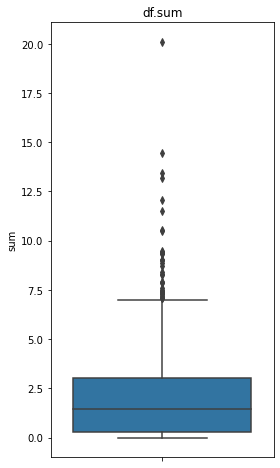

In [7]:
# According to the nature of the dataset (prepared manually without knowing it's future purpose), 
# we suspect a lot of outliers, so we will use bocplot method to identify and remove them

import seaborn as sns

plt.figure(figsize = (4,8))
sns.boxplot(y = df['sum'])
plt.title('df.sum')
    
def outlier_boundaries(df , column):
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # interquantile range
    iqr = q75 - q25
    # outlier boundary
    boundary = iqr * 1.5
    # lower and upper boundary values
    lower, upper = q25 - boundary, q75 + boundary
    print(f'The IQR is {iqr}')
    print(f'The lower boundary is {lower}')
    print(f'The upper boundaryis {upper}')
    # Calculate the number of records below and above lower and above bound value respectively
    df_upper = df[df[column] > upper]
    df_lower = df[df[column] < lower]
    return print(f'Total number of outliers are {len(df_upper) + len(df_lower)}')

outlier_boundaries(df , 'sum')

#  as more than 7 hours of learning is not realistic, the boundary seems right; we drop our outliers

df = df[df['sum']<7.050000000000001]

In [8]:
# creating label to predict (target value): binary classification learned(0) or not learned(1)

df['not_learned'] = df['sum'].apply(lambda x: 1 if x==0 else 0)
df['not_learned'].value_counts()

# we have an imbalanced dataset

0    1034
1     269
Name: not_learned, dtype: int64

In [9]:
# creating new variables

job = []

for date in df['date']:
    if date < pd.to_datetime('2018-07-01'):
        job.append(0)
    elif date >=pd.to_datetime('2018-07-01') and date <= pd.to_datetime('2019-11-30'):
         job.append(1)
    elif date >= pd.to_datetime('2019-12-01') and date <= pd.to_datetime('2021-11-30'):
        job.append(2)
    else:
        job.append(3)
        
df['job'] = job

# making dummy variables to deal with categorical feature 'job'

df = pd.get_dummies(df, columns=['job'], drop_first = True)

# adding more variables for circumstances that could affect language learning

df['R']=np.where((df['date'] >='2020-09-15')&(df['date'] <='2021-05-15'),1,0)
df['learningDS']=np.where((df['date'] >='2021-08-01'),1,0)
df['homeoffice']=np.where((df['date'] >='2020-03-16'),1,0)

# subscription gives access to more foreign language content (easier to spend some time learning), but can also distract

df['Netflix']=np.where((df['date'] >='2021-06-15'),1,0)

# while in journey, it is harder to find time to learn

df['journey'] = np.where(df['date'].isin(pd.date_range(start='9/13/2021', end='9/18/2021'))|
                      df['date'].isin(pd.date_range(start='5/11/2022', end='5/22/2022')) |
                        df['date'].isin(pd.date_range(start='9/9/2022', end='9/11/2022')) |
                           df['date'].isin(pd.date_range(start='9/24/2022', end='9/30/2022')) |
                                df['date'].isin(pd.date_range(start='10/31/2021', end='11/01/2021'))|
                                    df['date'].isin(pd.date_range(start='04/19/2019', end='04/22/2019'))|
                                        df['date'].isin(pd.date_range(start='04/10/2020', end='04/13/2020'))|
                                            df['date'].isin(pd.date_range(start='04/22/2021', end='04/24/2021'))|
                                                df['date'].isin(pd.date_range(start='04/15/2022', end='04/18/2022'))|
                                                     df['date'].isin(pd.date_range(start='08/16/2019', end='08/18/2019')),
                                                        1,0)
                       

# Having more time on holiday could help to learn more
 

holidays = ['06-01-2019', '01-05-2019', '02-05-2019','03-05-2019','15-08-2019','01-11-2019', '11-11-2019', '24-12-2019','22-04-2019',
           '06-01-2020', '01-05-2020', '02-05-2020','03-05-2020','15-08-2020','01-11-2020', '11-11-2020','24-12-2020','13-04-2020',
           '06-01-2021', '01-05-2021', '02-05-2021','03-05-2021','15-08-2021','01-11-2021', '11-11-2021','24-12-2021','05-04-2021',
           '06-01-2022', '01-05-2022', '02-05-2022','03-05-2022','15-08-2022','01-11-2022', '11-11-2022', '18-04-2022']

df['holiday'] = np.where(df['date'].isin(holidays),1,0 | df['date'].dt.dayofweek.isin([5,6]))

# presumably more time spent at home during lockdown could help to learn more
df['covid'] = np.where(df['date'].isin(pd.date_range(start='3/15/2020', end='3/15/2022')),1,0)

In [10]:
# The following derived features did not help models' performance

# df['mean_steps*journey'] = df['mean_steps']*df['journey']
# df['learningDS*journey'] = df['learningDS']*df['journey']
# df['R*Netflix'] = df['Netflix']*df['R']
# df['avg_course_day*journey'] = df['avg_course_day']*df['journey']
# df['journey*Netflix'] = df['Netflix']*df['journey']
# df['weekend*R'] = df['weekend']*df['R']


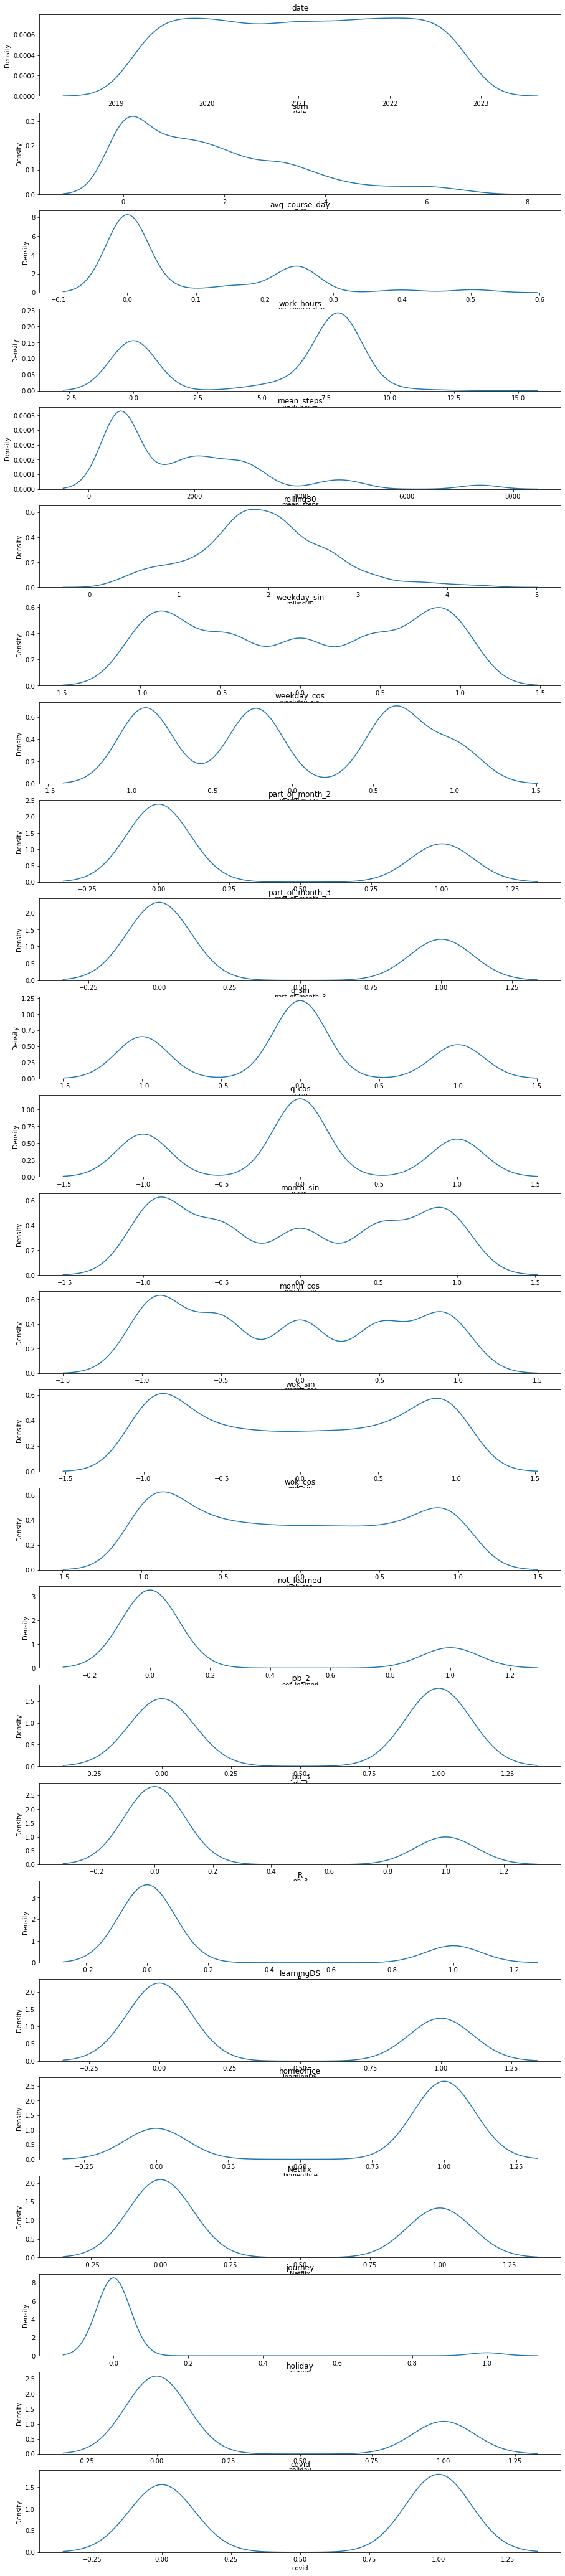

In [11]:
# checking features distribution to catch some mistakes in column creation and check 
# how much the distribution is different from normal distribution in case of continous features
# we can see that the distribution is not normal for most columns, which might decrease the performance of our models; 
# we will try transforming the skewed columns by square transformations


import seaborn as sns

fig = plt.figure(figsize=(15,75))
position = 1
for i in df.columns[0:len(df.columns)]:
    ax = fig.add_subplot(len(df.columns),1,position)
    position = position + 1
    sns.kdeplot(df[i],ax=ax)
    plt.title(i)



In [12]:
# we have positive skew for columns' avg_course_day and mean_steps; we will try to replace their values with 
# their square root to reduce that and thus improve performance of our models;
# log transformation would be more efficient, but since we have many zeroes in our columns, it cannot be used
# work hours seems to be slightly positively skewed; we will try square of it's value to diminish the effect of skewness

df['avg_course_day'] = np.sqrt(df['avg_course_day'])
df['mean_steps'] = np.sqrt(df['mean_steps'])
df['work_hours'] = np.power(df['work_hours'], 2)


Text(0.5, 1.0, 'Points sorted by distance to the 33th nearest neighbor')

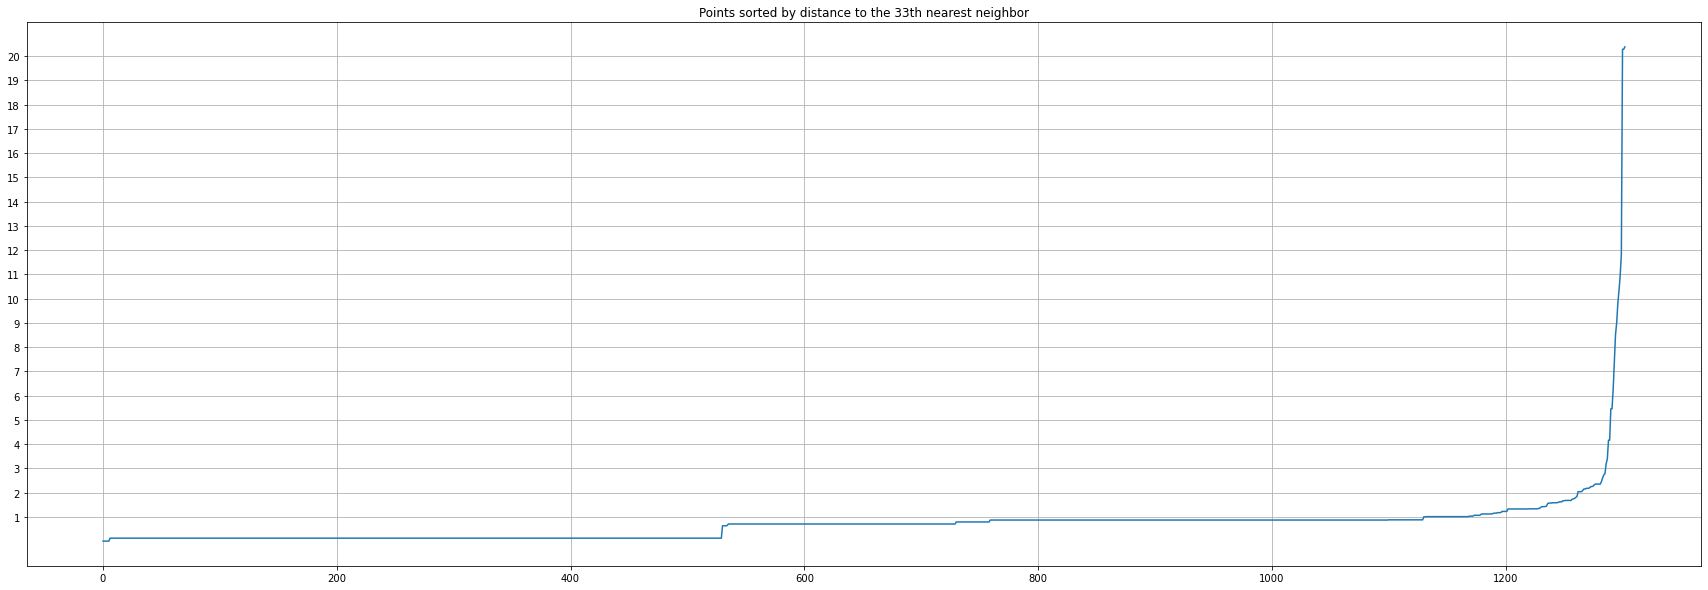

In [13]:
# Adding DBSCAN cluster as a feature improves performance; 
# we drop the columns that could cause information leakage before fitting

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import math

n_neighbors = math.ceil((len(df.drop(['date', 'not_learned', 'sum', 'rolling30'], axis=1).columns)*1.5))
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(df.drop(['date', 'not_learned', 'sum', 'rolling30'], axis=1))
distances, indices = neighbors_fit.kneighbors(df.drop(['date', 'not_learned', 'sum', 'rolling30'], axis=1))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.yticks(ticks=[1,2,3,4,5,6,7,8,9,10,11, 12,13,14,15,16,17,18,19,20])
plt.grid(True)
plt.title(f'Points sorted by distance to the {n_neighbors}th nearest neighbor')

In [14]:
dbscan = DBSCAN(eps = 3,min_samples = n_neighbors)
model = dbscan.fit(df.drop(['not_learned', 'date', 'sum', 'rolling30'], axis=1).iloc[:,1:-1])
labels = model.labels_
df['dbscan']= labels
df = pd.get_dummies(df, columns=['dbscan'], drop_first = True)

In [15]:
# df['dbscan']= labels
# pd.value_counts(df['dbscan'])

<AxesSubplot:>

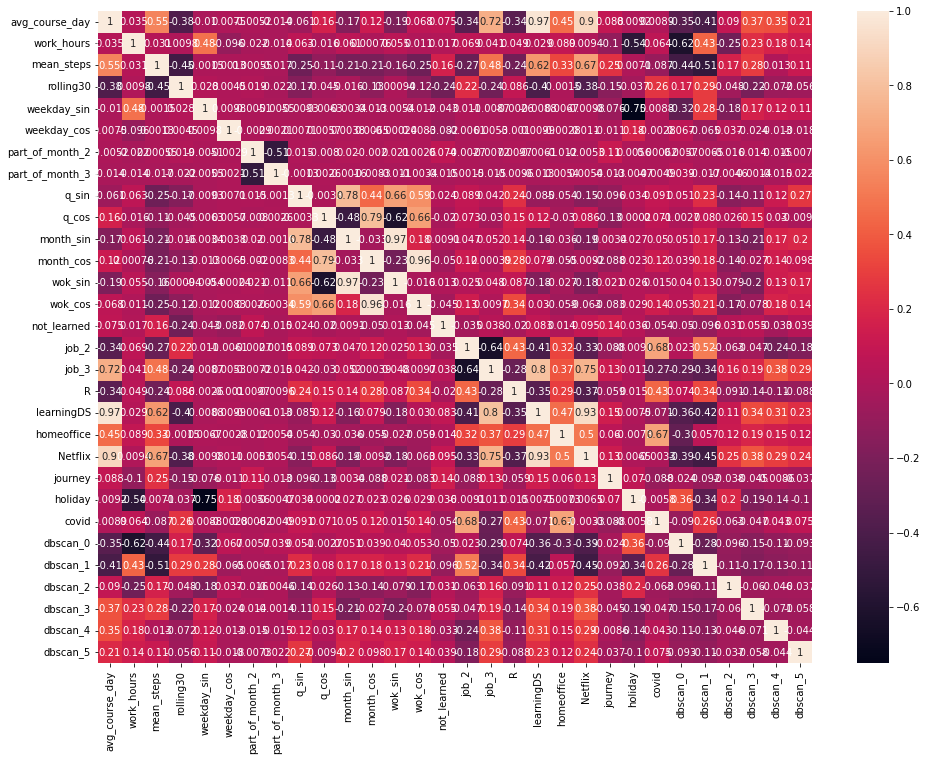

In [16]:
# We make a heatmap to have a glance at correlation of features with target value and with each other 

import seaborn as sns 
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
sns.heatmap(df.iloc[:,2:len(df.columns)].corr(),annot=True)

# we have a lot of correlation between variable pairs;
# we might consider dropping some variables
# we will use standardization and pca as elements of our model pipeline , which can help to deal with multicollinearity

In [17]:
# quick glance at the distribution of target variable by different variables;

print(round(df['not_learned'].mean()*100,2), '% of samples belong to 1 class')
print('------------------------------')
print(df.groupby('job_2')['not_learned'].mean())
print('------------------------------')
print(df.groupby('job_3')['not_learned'].mean())
print('------------------------------')
print(df.groupby('holiday')['not_learned'].mean())
print('------------------------------')
print(df.groupby('covid')['not_learned'].mean())
print('------------------------------')
print(df.groupby('Netflix')['not_learned'].mean())
print('------------------------------')
print(df.groupby('learningDS')['not_learned'].mean())
print('------------------------------')
print(df.groupby('R')['not_learned'].mean())
print('------------------------------')
print(df.groupby('journey')['not_learned'].mean())



20.64 % of samples belong to 1 class
------------------------------
job_2
0    0.221488
1    0.193410
Name: not_learned, dtype: float64
------------------------------
job_3
0    0.197300
1    0.232353
Name: not_learned, dtype: float64
------------------------------
holiday
0    0.196953
1    0.229167
Name: not_learned, dtype: float64
------------------------------
covid
0    0.229752
1    0.186246
Name: not_learned, dtype: float64
------------------------------
Netflix
0    0.175659
1    0.254941
Name: not_learned, dtype: float64
------------------------------
learningDS
0    0.181710
1    0.251627
Name: not_learned, dtype: float64
------------------------------
R
0    0.210280
1    0.188841
Name: not_learned, dtype: float64
------------------------------
journey
0    0.195219
1    0.500000
Name: not_learned, dtype: float64


In [18]:
# Dropping y, date and columns that are leaking information from target column
y = df['not_learned']
X = df.drop(['not_learned', 'date', 'sum', 'rolling30'], axis = 1)

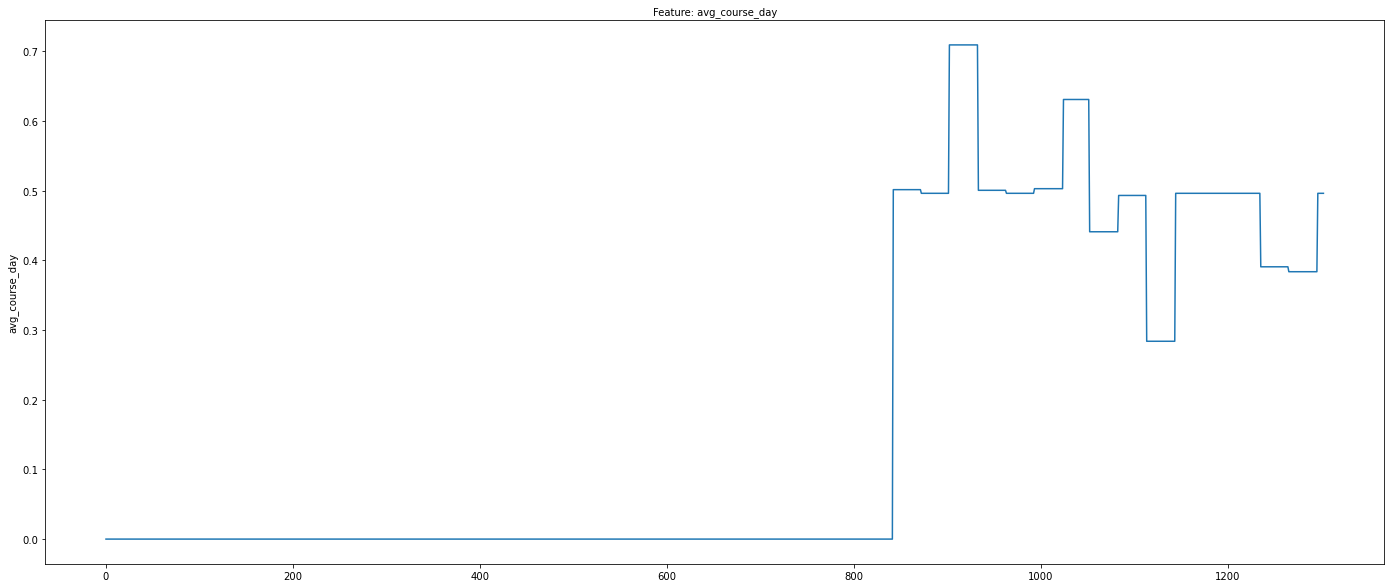

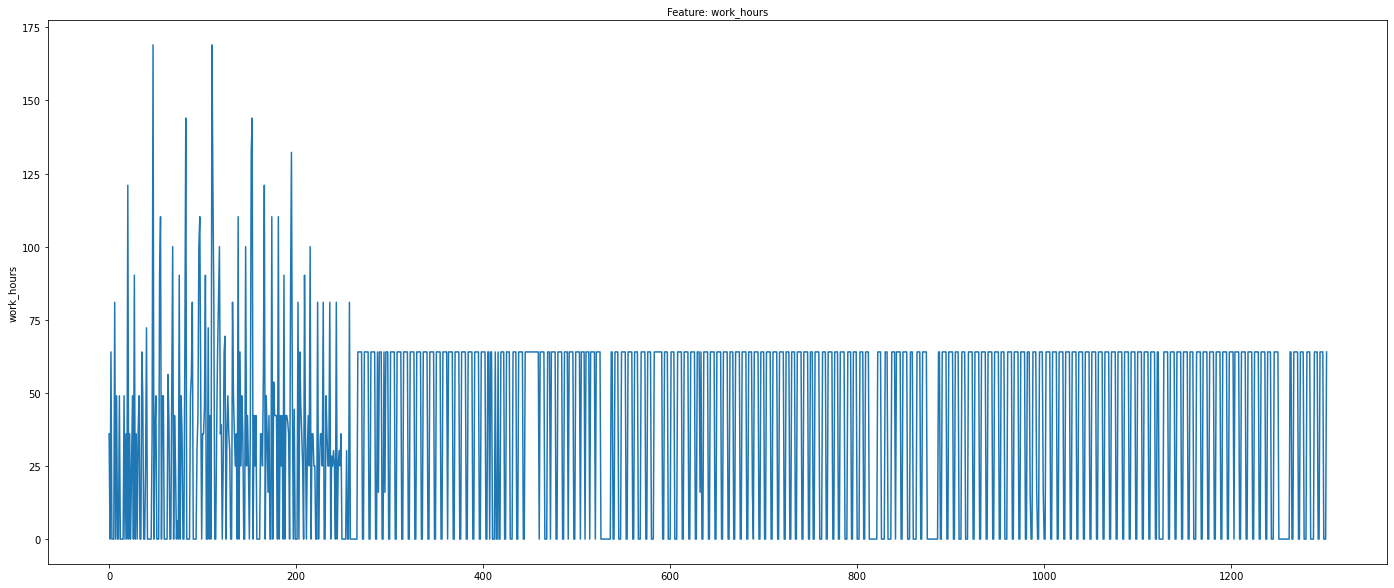

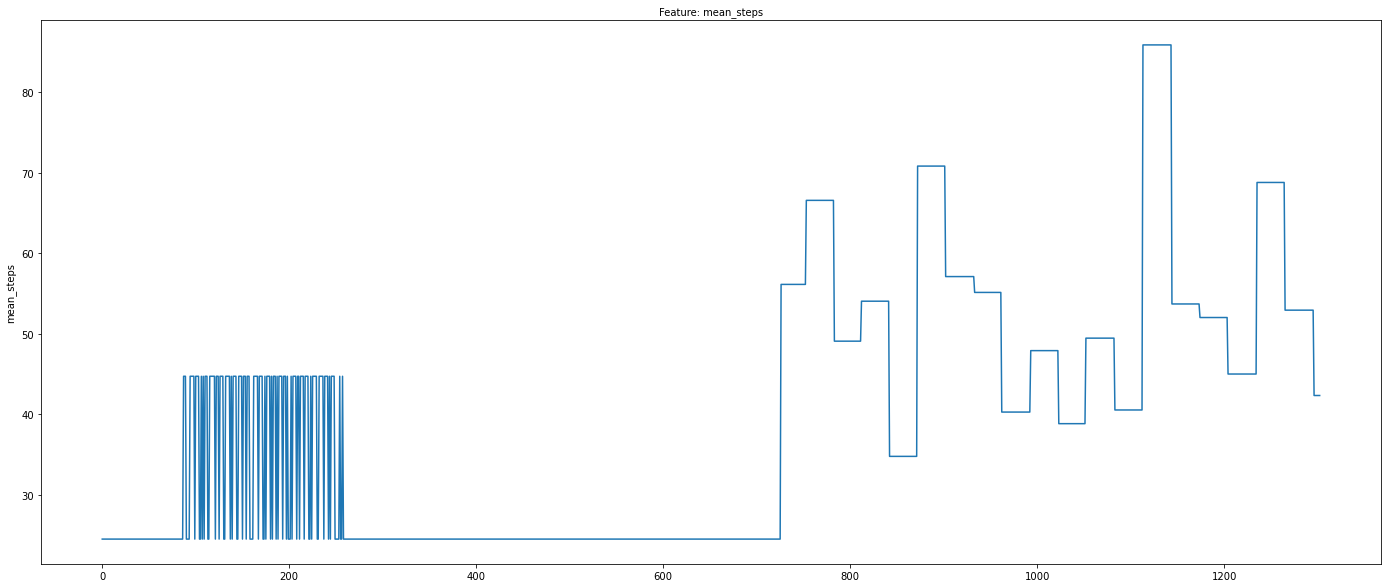

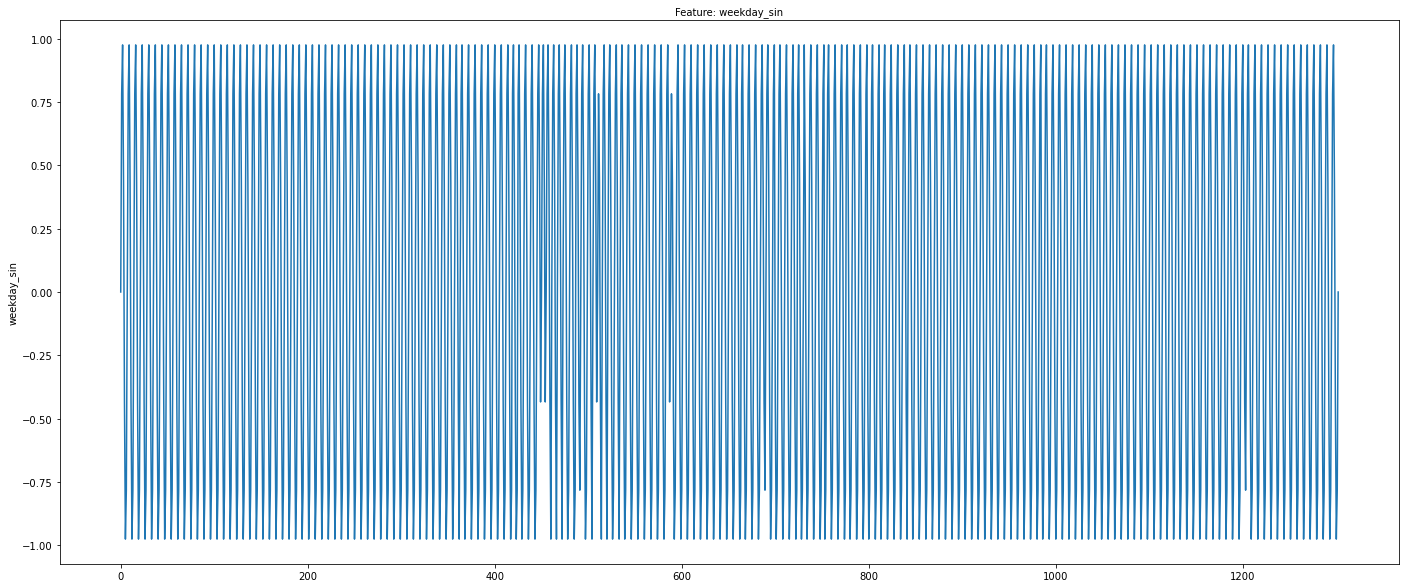

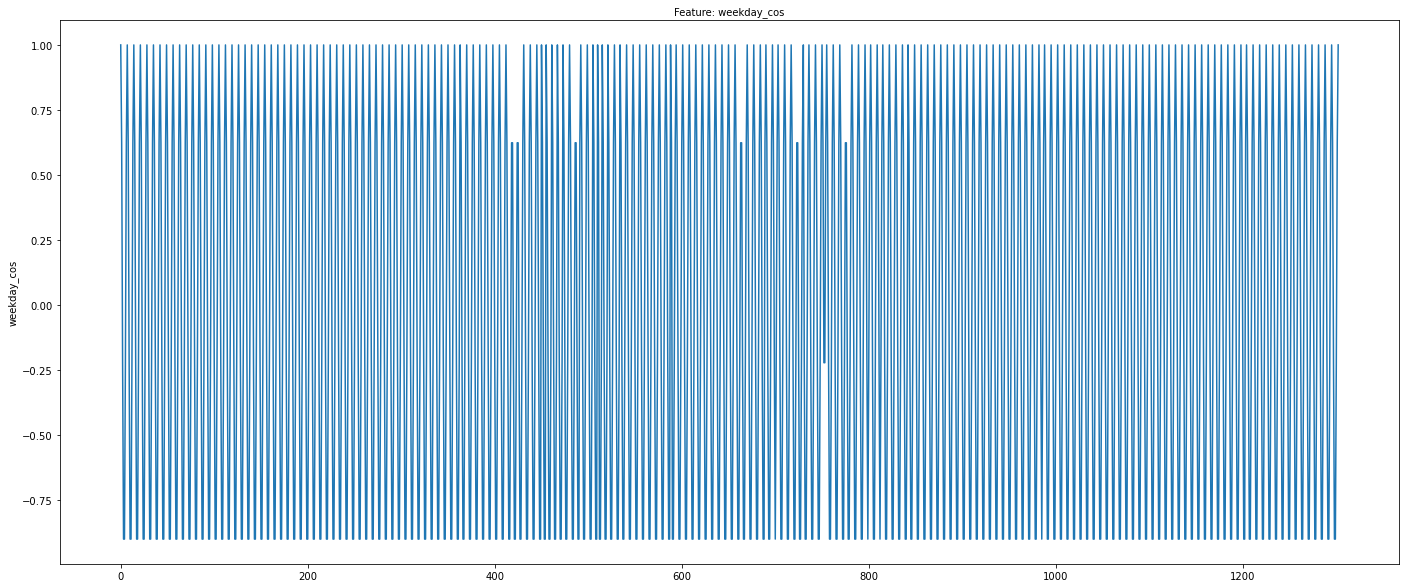

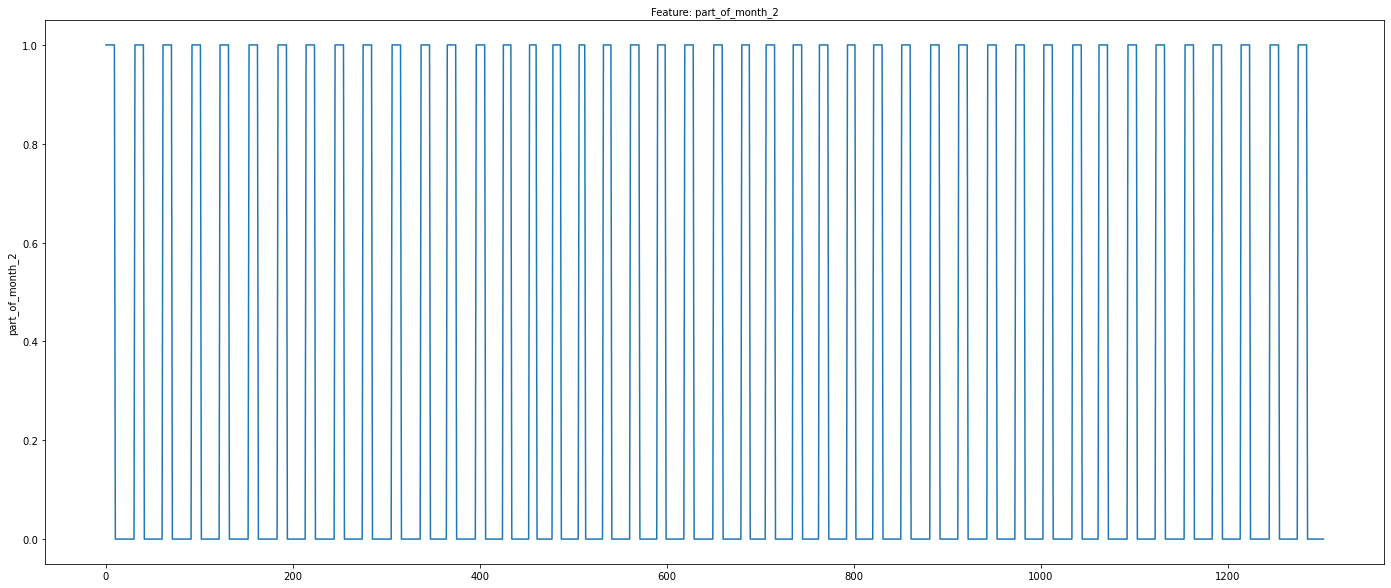

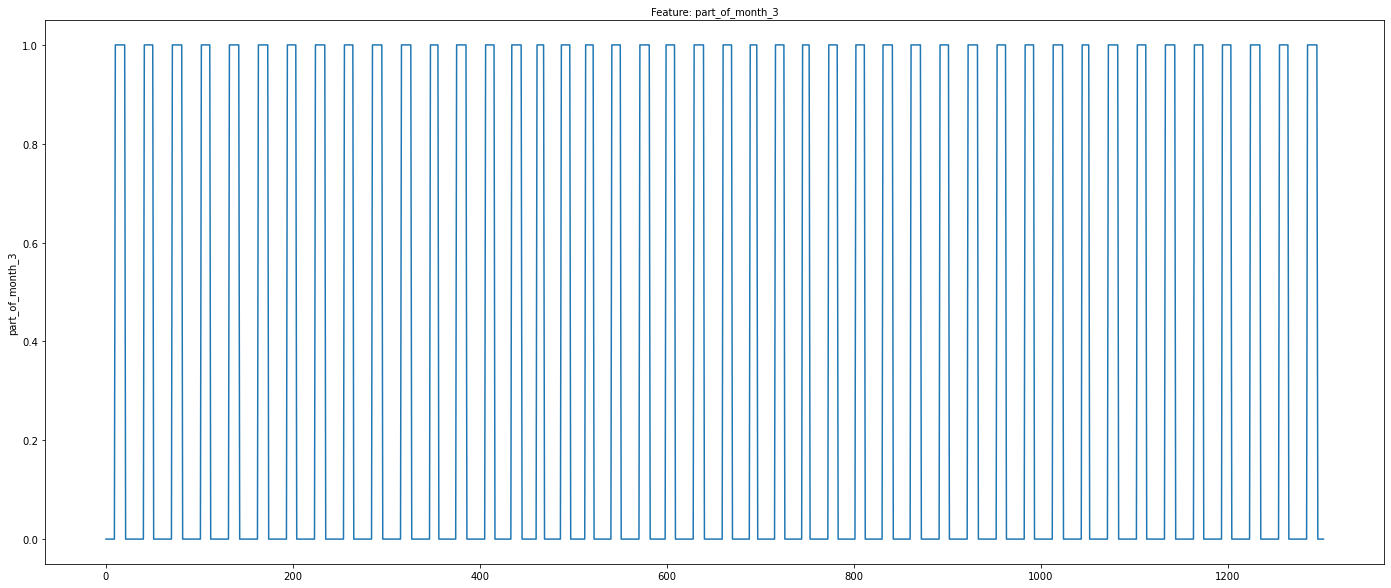

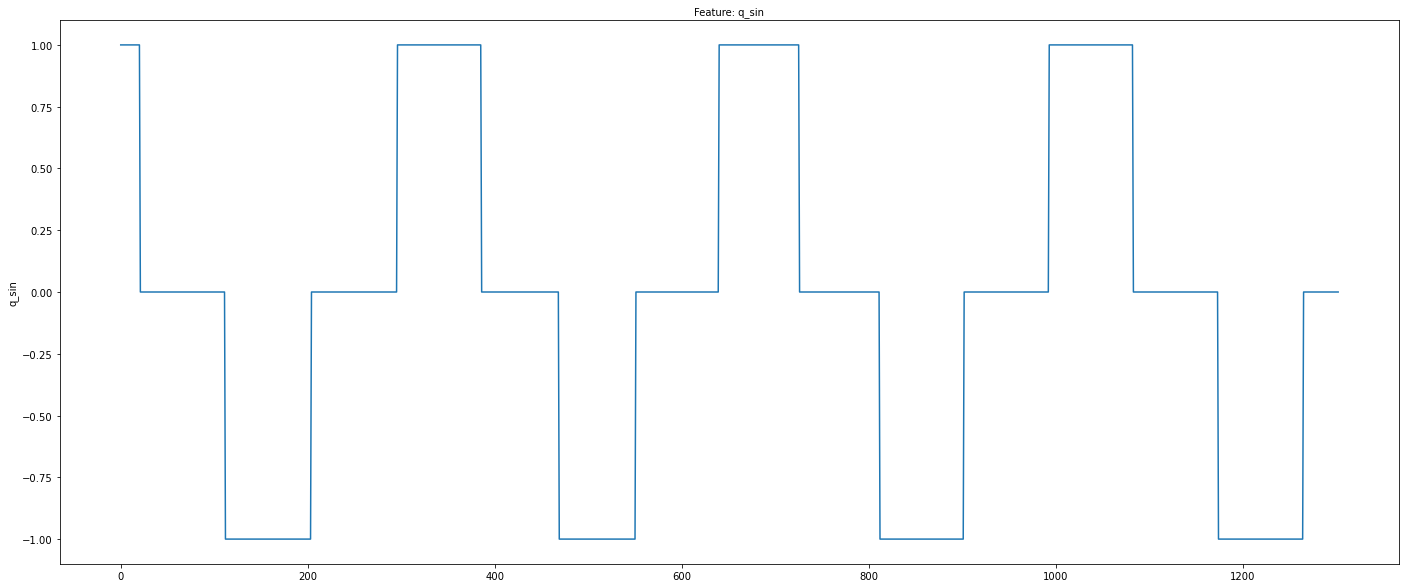

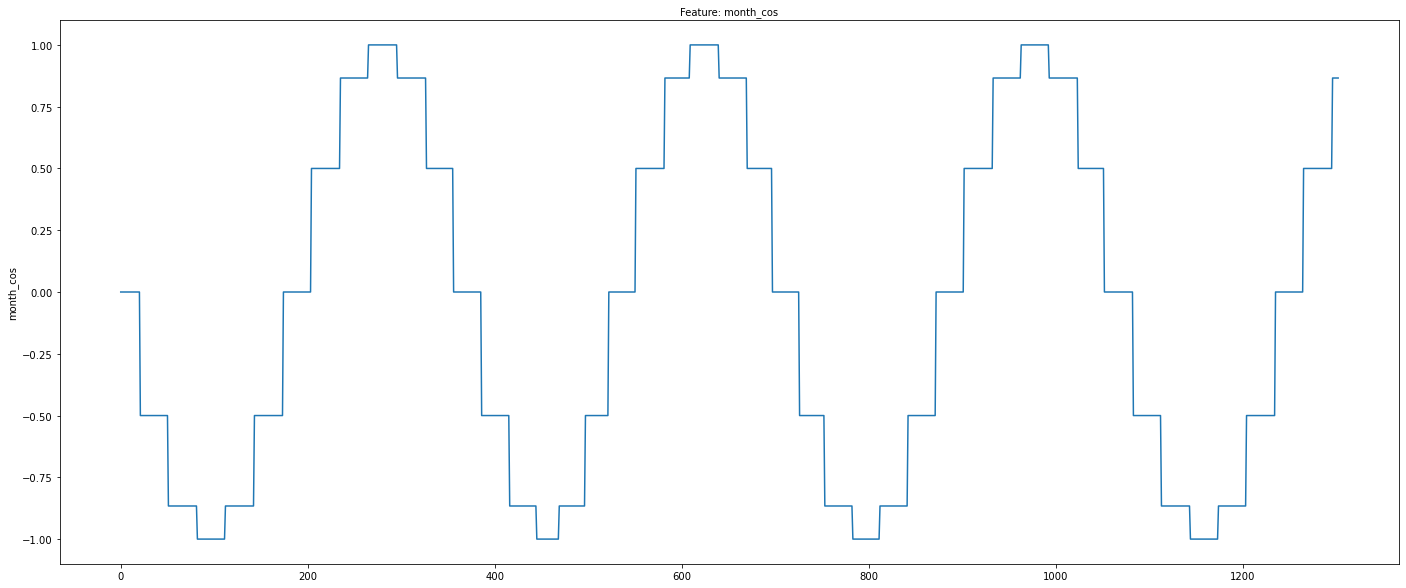

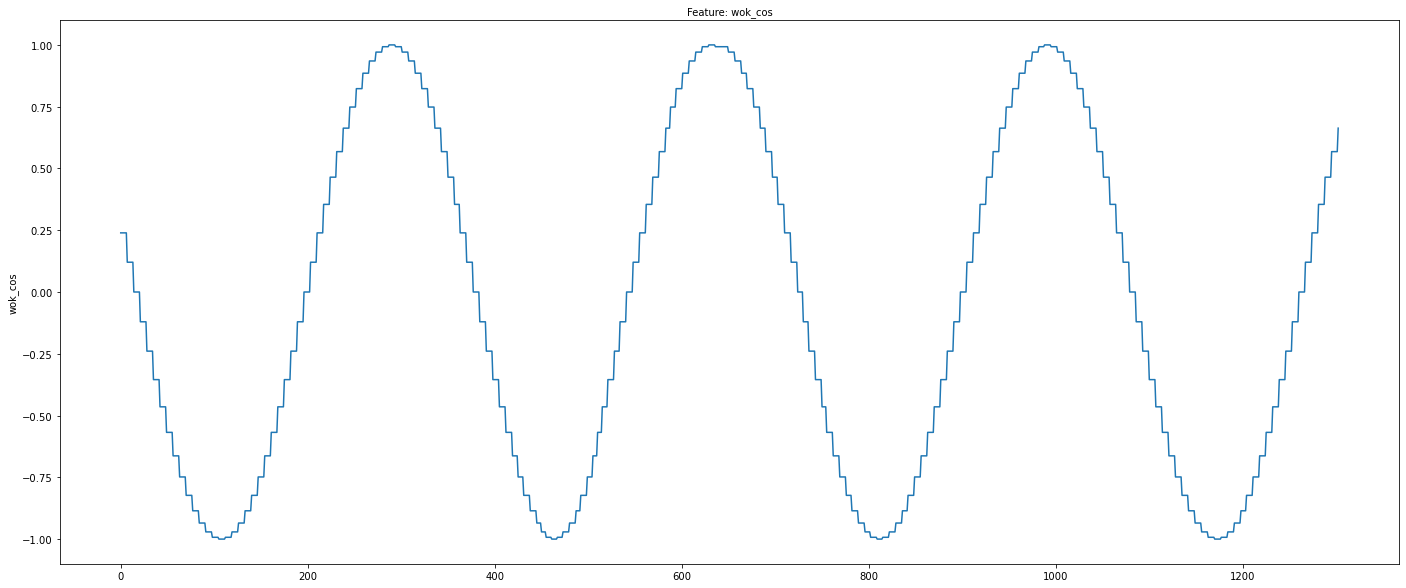

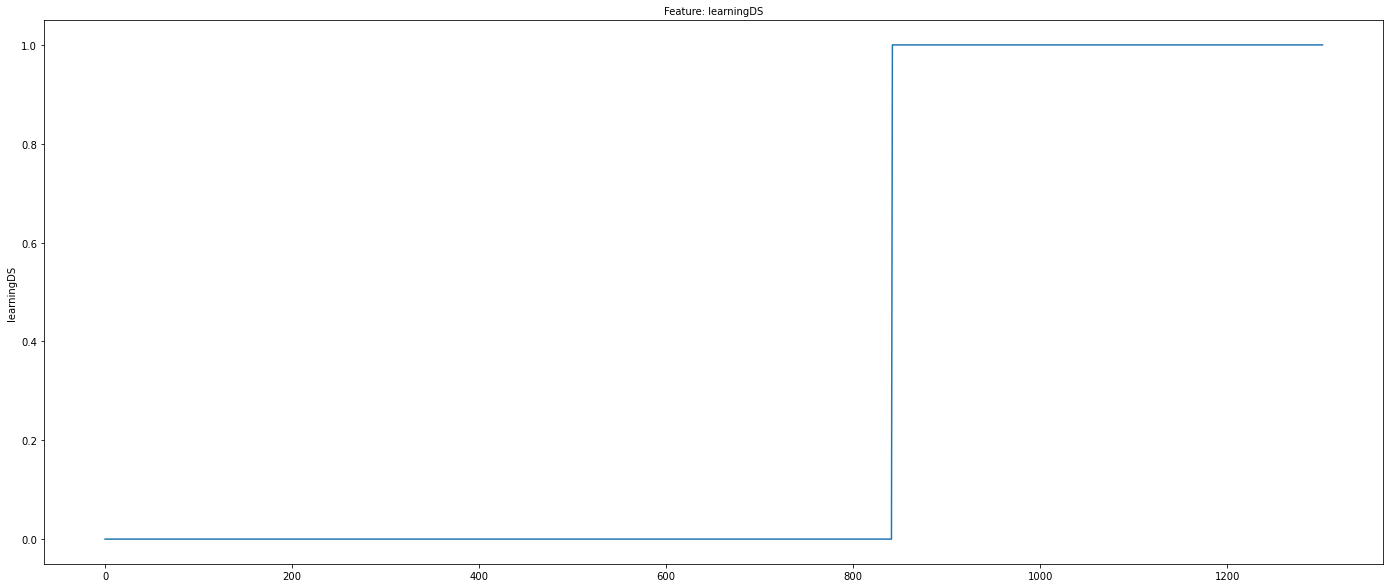

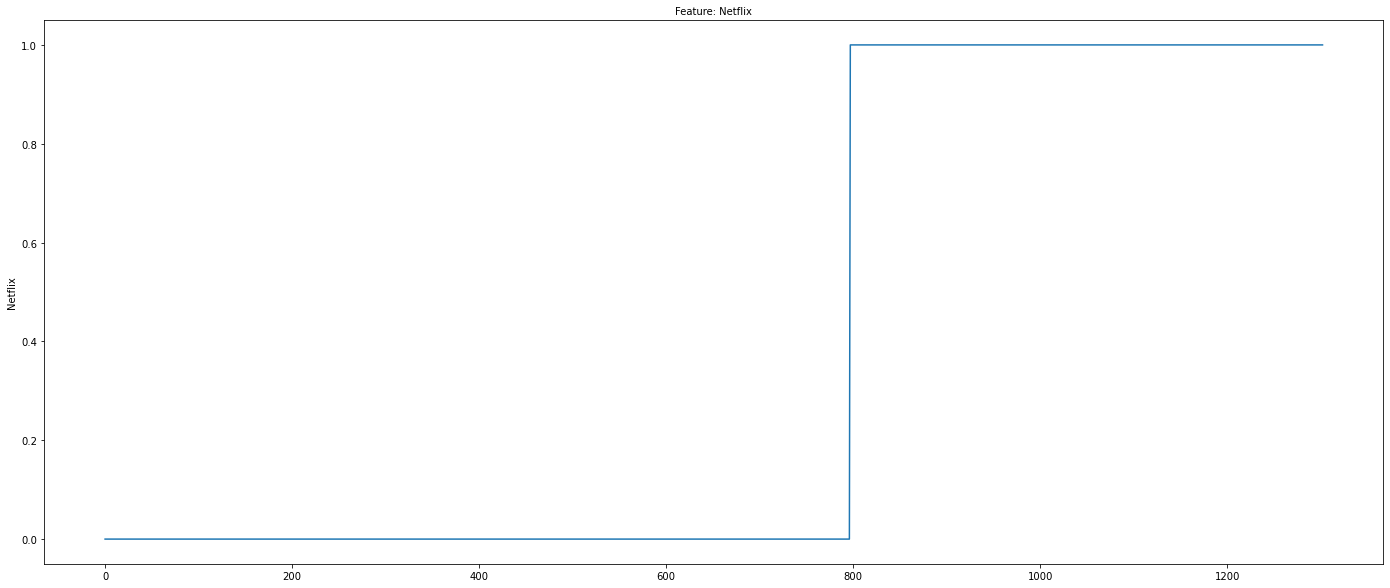

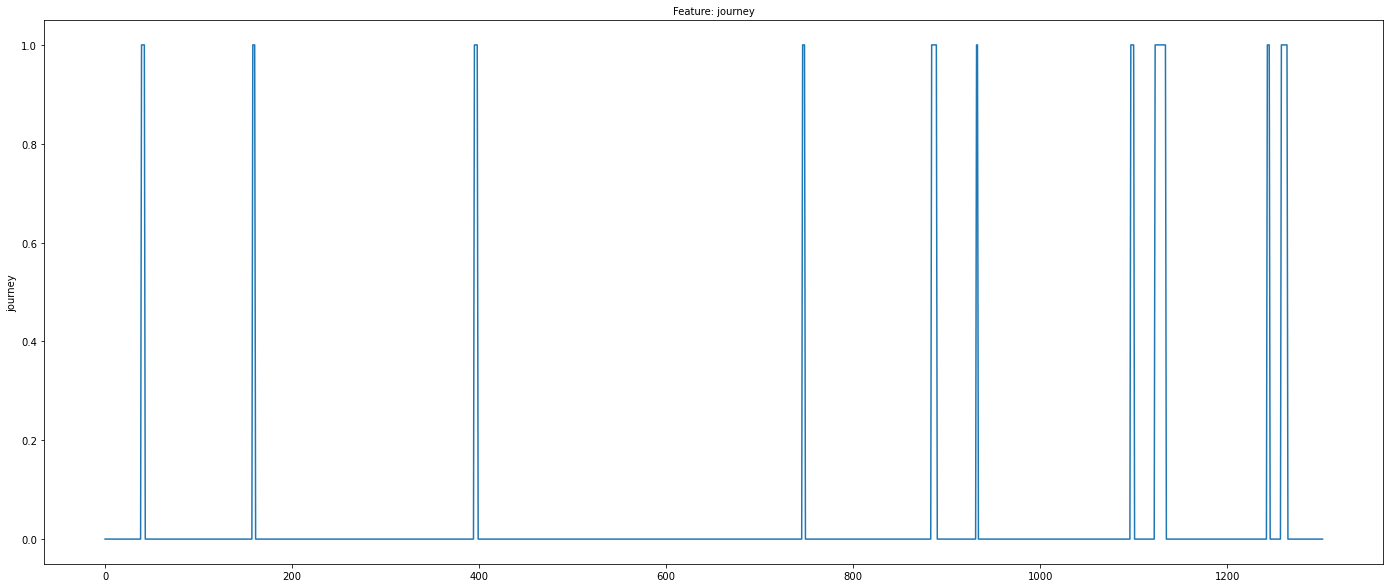

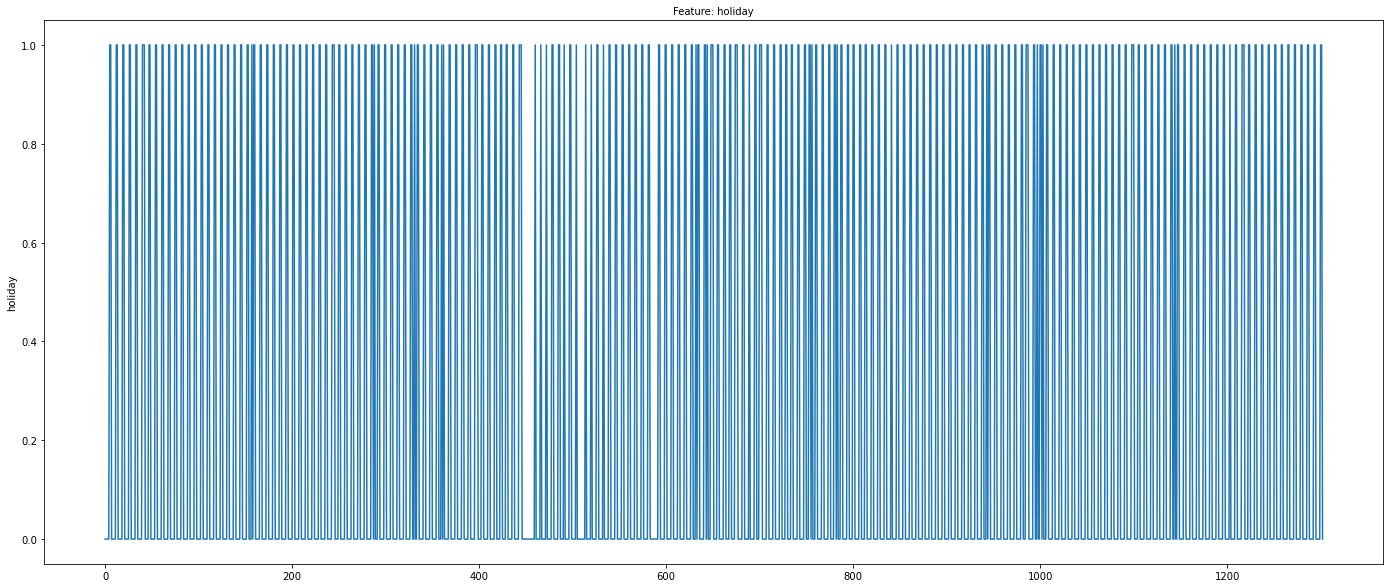

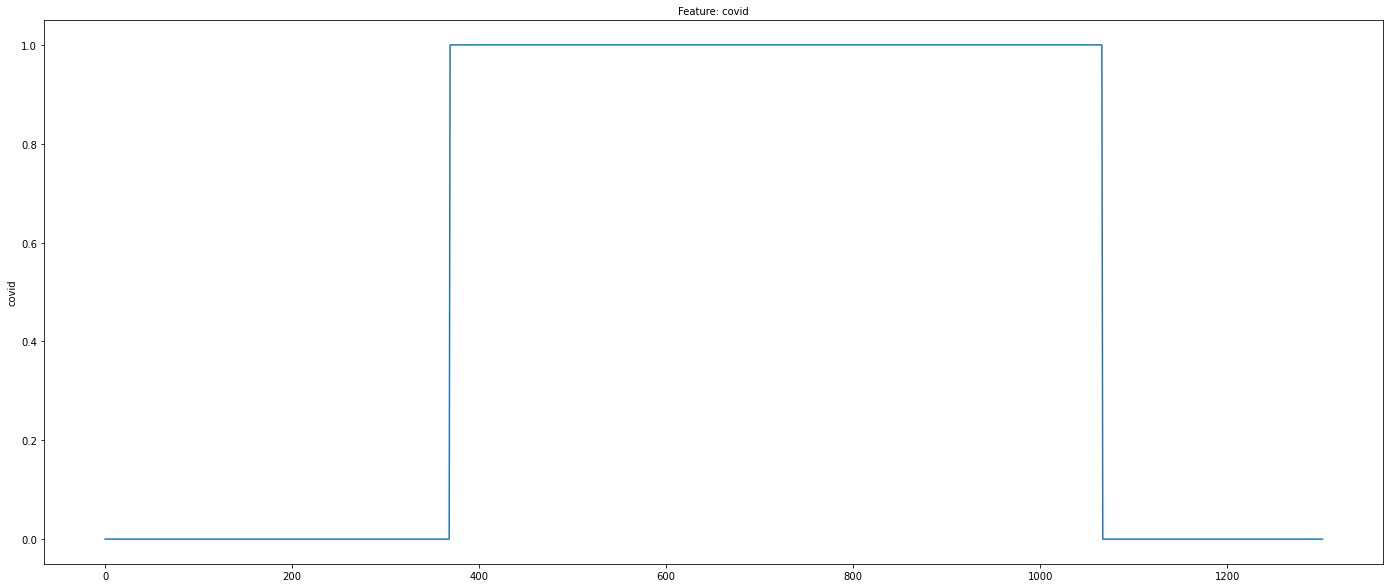

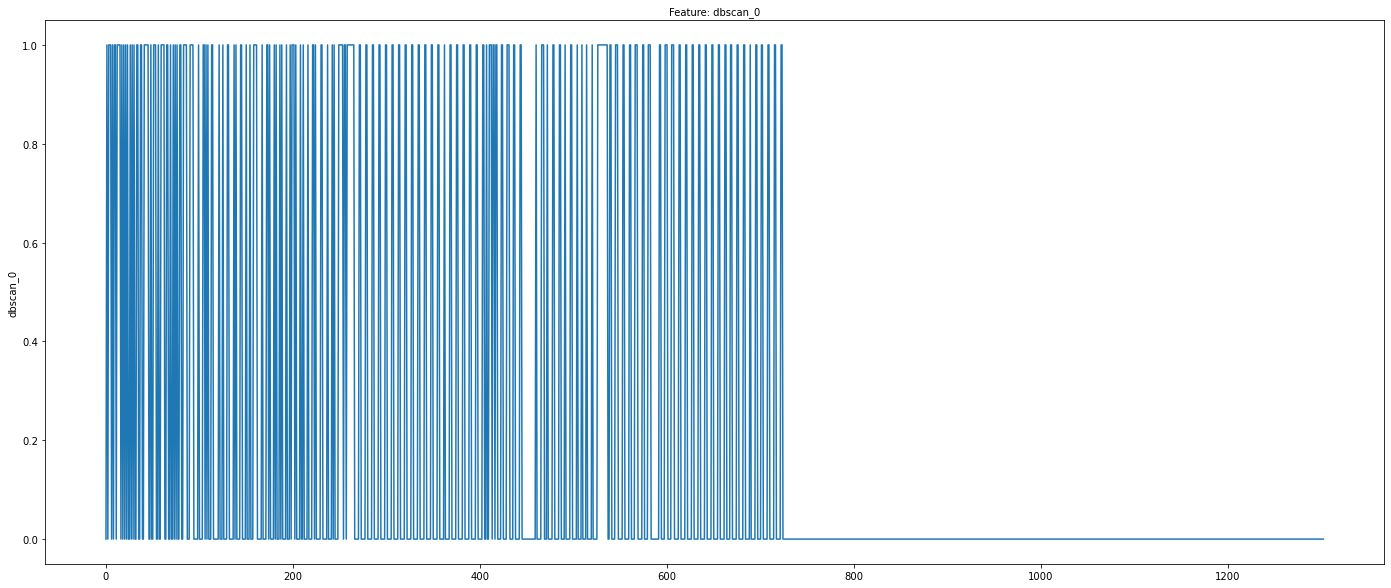

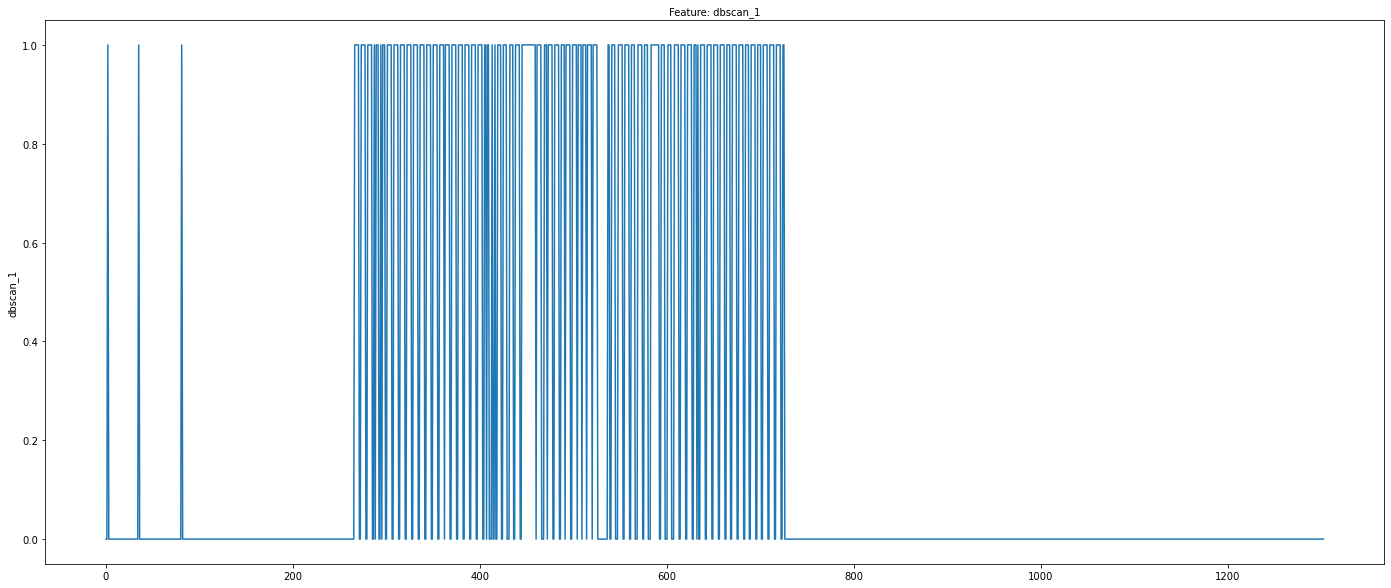

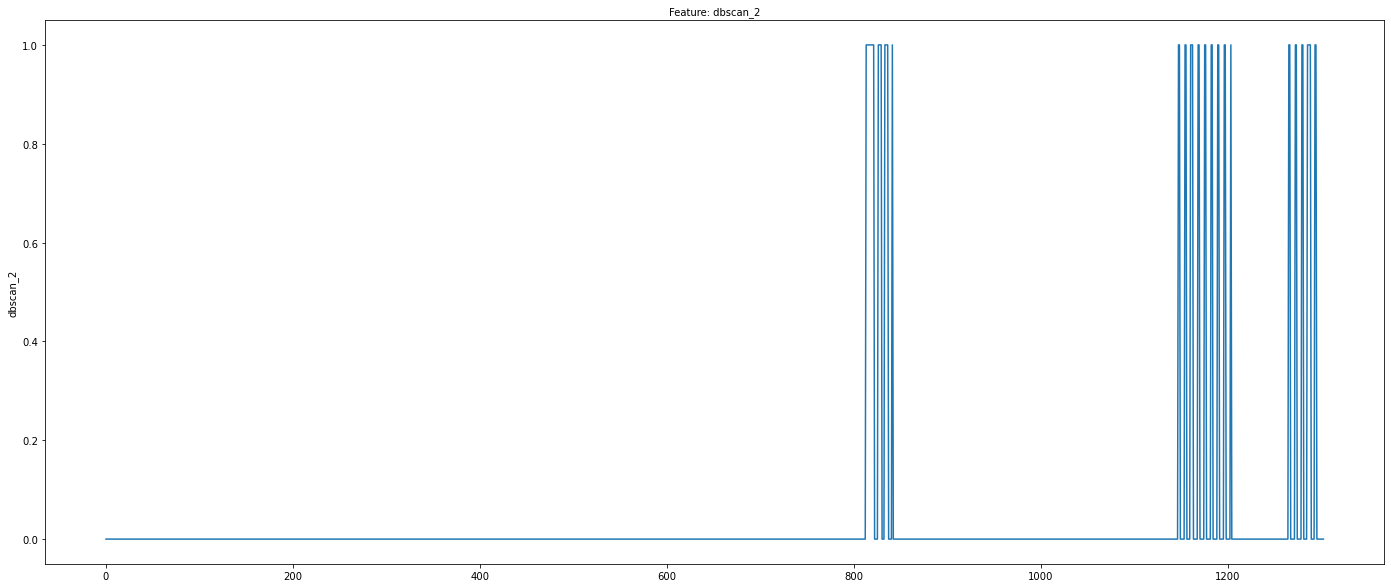

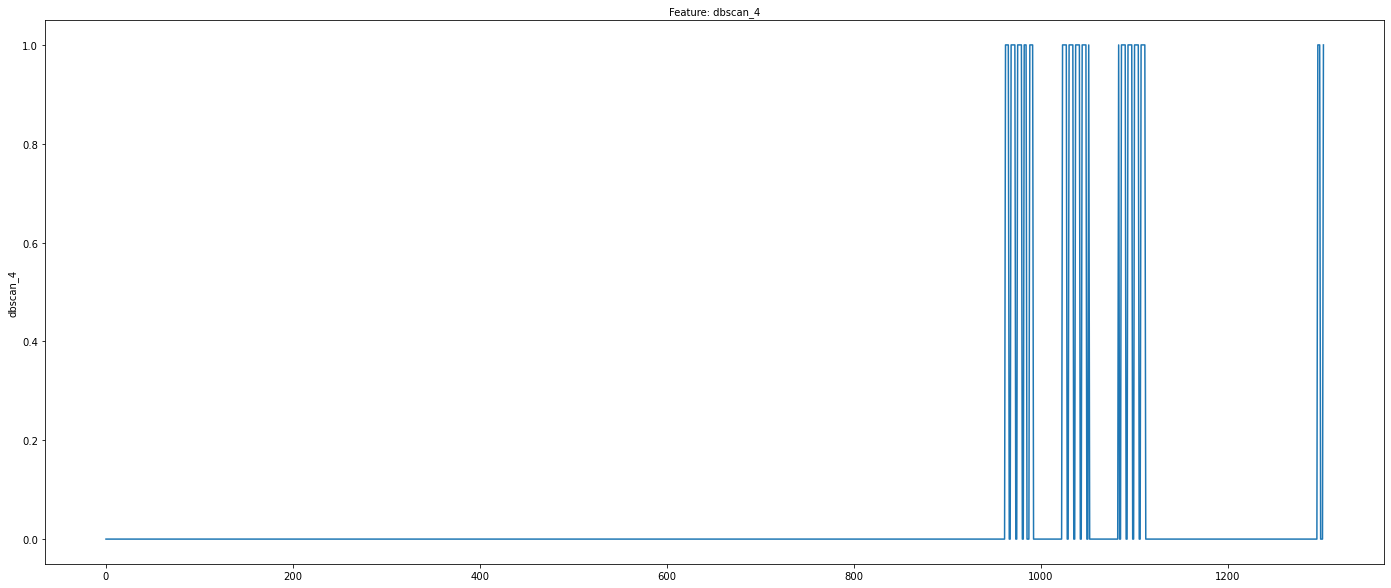

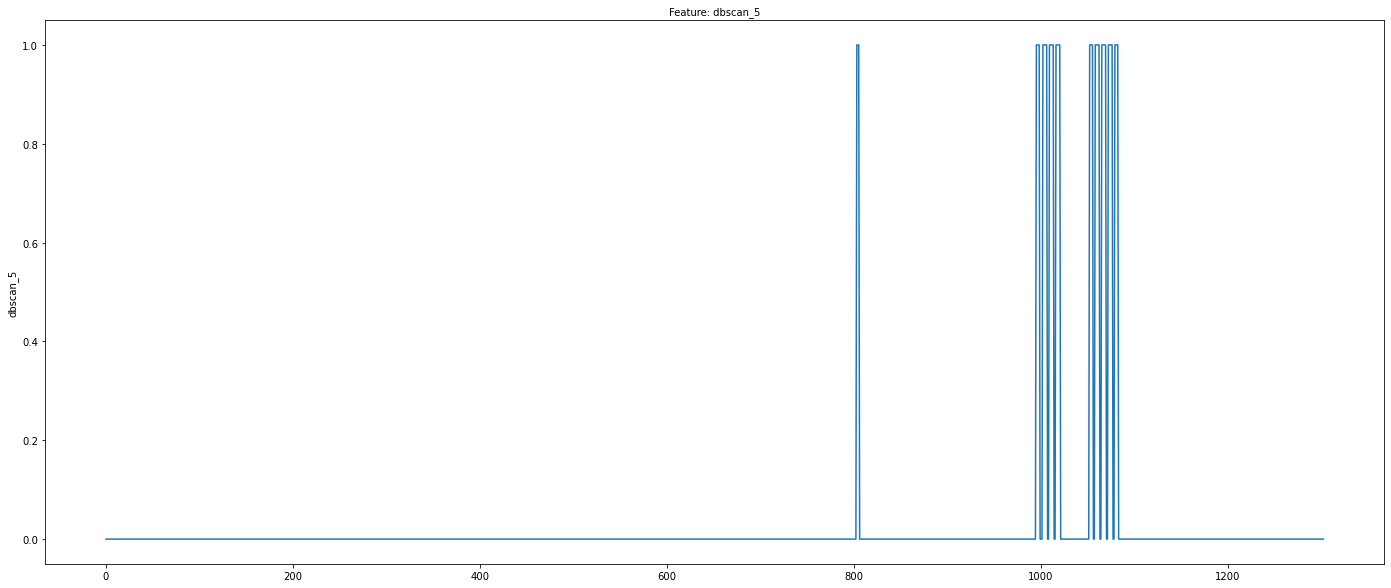

In [19]:
# Last check of lineplots to make sure features have expected values
for i in X.columns:
    fig = plt.figure(figsize=(24,10))
    ax = plt.subplot()
    sns.lineplot(x=range(0,len(df)), y=X[i], ax = ax)
    ax.set_title(f'Feature: {i}', fontsize=10)
    ax.set_ylabel(ylabel=f'{i}', fontsize=10)


In [20]:
# we make train, test and validation set (instead of only train-test) to tune parameters more easily

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=0, stratify=y_train)


In [21]:
# using pipeline to avoid information leakage in further cross validation 
# scaling can affect the score of LogisticRegression, KNN and SVM which we will be trying later;
# we will include it in the pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = PCA(n_components=0.99)

# First testing various models, to get an idea which one might perform well 
# we can test many models, because the dataset is small, so this won't take too much time
# importing all necessary libraries/modules/classifiers/metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import pickle


In [22]:
# comparing models


classifiers = [RandomForestClassifier(),
               DecisionTreeClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               ExtraTreesClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    BernoulliNB(),
    SVC(), 
              ]



def compare_models(classifiers, X_train, y_train, sort_by_metric):
    metrics=['recall','roc_auc', 'precision','accuracy']
    print(f'features used: {X_train.columns}')
    scores_df = pd.DataFrame(np.zeros((len(classifiers),5)), columns = ['name', *metrics])
    for i in range(0,len(classifiers)):
        model = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifiers[i])])
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
        scores = cross_validate(model, X_train, y_train, scoring=metrics, cv=cv, n_jobs=-1, error_score="raise")
        scores_df['name']=classifiers
        scores_df.at[i,'recall']=np.mean(scores['test_recall'])
        scores_df.at[i,'roc_auc']=np.mean(scores['test_roc_auc'])
        scores_df.at[i,'precision']=np.mean(scores['test_precision'])
        scores_df.at[i,'accuracy']=np.mean(scores['test_accuracy'])
    scores_df = scores_df.sort_values(by=[sort_by_metric], ascending = False)
    return scores_df



first_comparison = compare_models(classifiers, X_train, y_train, 'recall')
first_comparison

features used: Index(['avg_course_day', 'work_hours', 'mean_steps', 'weekday_sin',
       'weekday_cos', 'part_of_month_2', 'part_of_month_3', 'q_sin', 'q_cos',
       'month_sin', 'month_cos', 'wok_sin', 'wok_cos', 'job_2', 'job_3', 'R',
       'learningDS', 'homeoffice', 'Netflix', 'journey', 'holiday', 'covid',
       'dbscan_0', 'dbscan_1', 'dbscan_2', 'dbscan_3', 'dbscan_4', 'dbscan_5'],
      dtype='object')


name    recall   roc_auc  \
1                            DecisionTreeClassifier()  0.325902  0.571578   
6   XGBClassifier(base_score=None, booster=None, c...  0.222610  0.668841   
8                                        GaussianNB()  0.219110  0.641576   
4                              ExtraTreesClassifier()  0.213171  0.680175   
7                              KNeighborsClassifier()  0.183854  0.667312   
0                            RandomForestClassifier()  0.178000  0.676653   
2                                AdaBoostClassifier()  0.177012  0.630887   
3                        GradientBoostingClassifier()  0.169207  0.665174   
5                                LogisticRegression()  0.088768  0.632830   
10                                              SVC()  0.048988  0.660152   
9                                       BernoulliNB()  0.033817  0.616998   

    precision  accuracy  
1    0.318373  0.715533  
6    0.353127  0.755635  
8    0.395219  0.765584  
4    0.379285  0.764365  
7    0.383893  0.768426  
0    0.402625  0.774315  
2    0.374472  0.768122  
3    0.430841  0.781117  
5    0.594690  0.798883  
10   0.623095  0.796142  
9    0.364468  0.790152

In [23]:
# We will balance classess adding the class_weight parameter to the models that support this hyperparameter, 
# and see how does it change the overall performance;

classifiers = [RandomForestClassifier(class_weight="balanced"),
               DecisionTreeClassifier(class_weight="balanced"),
               ExtraTreesClassifier(class_weight="balanced"),
    LogisticRegression(class_weight="balanced"),
    XGBClassifier(class_weight="balanced"),
    SVC(class_weight="balanced")]
 
first_comparison = compare_models(classifiers, X_train, y_train, 'recall')

first_comparison

features used: Index(['avg_course_day', 'work_hours', 'mean_steps', 'weekday_sin',
       'weekday_cos', 'part_of_month_2', 'part_of_month_3', 'q_sin', 'q_cos',
       'month_sin', 'month_cos', 'wok_sin', 'wok_cos', 'job_2', 'job_3', 'R',
       'learningDS', 'homeoffice', 'Netflix', 'journey', 'holiday', 'covid',
       'dbscan_0', 'dbscan_1', 'dbscan_2', 'dbscan_3', 'dbscan_4', 'dbscan_5'],
      dtype='object')


name    recall   roc_auc  \
5                       SVC(class_weight='balanced')  0.575549  0.687598   
3        LogisticRegression(class_weight='balanced')  0.541098  0.625044   
1    DecisionTreeClassifier(class_weight='balanced')  0.324598  0.577946   
4  XGBClassifier(base_score=None, booster=None, c...  0.219976  0.671363   
2      ExtraTreesClassifier(class_weight='balanced')  0.214671  0.671397   
0    RandomForestClassifier(class_weight='balanced')  0.164183  0.689553   

   precision  accuracy  
5   0.315857  0.654416  
3   0.271065  0.603249  
1   0.334054  0.726396  
4   0.358607  0.756548  
2   0.377903  0.764264  
0   0.424803  0.781320

In [24]:
# In order to avoid multicollinearityit was possible to use pca  or perform feature selection; 
# PCA gives better results in terms of our models' performance, so we are commenting the code for feature selection


from sklearn.feature_selection import SelectKBest, f_classif

def select_k_for_k_best(X_train, y_train, classifier, score_func):
    scores_df = pd.DataFrame(np.zeros((len(X_train.columns),5)), columns =['i','recall','roc_auc', 'precision','accuracy'])
    for i in range(1,len(X_train.columns)+1):
        feature_selector=SelectKBest(score_func=score_func,k=i)
        model = Pipeline([('scaler',scaler),('feature_selector',feature_selector),('classifier', classifier)])
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
        scoring = ['recall','roc_auc', 'precision','accuracy']
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score="raise")
        scores_df.at[i-1,'i']=i
        scores_df.at[i-1,'recall']=np.mean(scores['test_recall'])
        scores_df.at[i-1,'roc_auc']=np.mean(scores['test_roc_auc'])
        scores_df.at[i-1,'precision']=np.mean(scores['test_precision'])
        scores_df.at[i-1,'accuracy']=np.mean(scores['test_accuracy'])
    return scores_df
    


In [25]:
# k_best_data_f_reg_SVC = select_k_for_k_best(X_train, y_train, SVC(class_weight='balanced', probability=True), score_func=f_classif)
# k_best_data_f_reg_SVC.sort_values(by='recall', ascending = False)[0:4]

In [26]:
# k_best_data_f_reg_LR = select_k_for_k_best(X_train, y_train, LogisticRegression(class_weight='balanced'), score_func=f_classif)
# k_best_data_f_reg_LR.sort_values(by='recall', ascending = False)[0:4]

In [27]:
# Best features for SVC
# k = 29
# feature_selector=SelectKBest(score_func=f_classif,k=k)
# feature_selector.fit(X_train, y_train)
# mask = feature_selector.get_support()
# new_features = X_train.columns[mask]
# print(f'for SVC our best {k}  features are:')
# print (new_features)
# print('------------------------------------')


In [28]:
# X_kbest = ['avg_course_day', 'mean_steps', 'weekday_sin', 'weekday_cos',
#        'part_of_month_2', 'month_3', 'month_4', 'month_5', 'month_6',
#        'month_7', 'month_10', 'month_11', 'month_12', 'q_sin', 'q_cos',
#        'month_sin', 'month_cos', 'wok_sin', 'wok_cos', 'job_2', 'job_3',
#        'learningDS', 'Netflix', 'journey', 'holiday', 'delta_age', 'covid',
#        'dbscan_0', 'dbscan_1']

# X_train_svc =  X_train[X_kbest]
# X_val_svc = X_val[X_kbest]
# X_test_svc =  X_test[X_kbest]

In [29]:
# # Best Features for LogisticRegression

# k = 34
# feature_selector=SelectKBest(score_func=f_classif,k=k)
# feature_selector.fit(X_train, y_train)
# mask = feature_selector.get_support()
# new_features = X_train.columns[mask]

# print(f'for LogisticRegression our best {k} features are:')
# print (new_features)
# print('------------------------------------')


In [30]:
# X_kbest = ['avg_course_day', 'work_hours', 'mean_steps', 'weekday_sin',
#        'weekday_cos', 'part_of_month_2', 'month_3', 'month_4', 'month_5',
#        'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
#        'month_12', 'q_sin', 'q_cos', 'month_sin', 'month_cos', 'wok_sin',
#        'wok_cos', 'job_2', 'job_3', 'R', 'learningDS', 'homeoffice', 'Netflix',
#        'journey', 'holiday', 'delta_age', 'covid', 'dbscan_0', 'dbscan_1']

# X_train_lr = X_train[X_kbest]

# X_val_lr = X_val[X_kbest]
# X_test_lr = X_test[X_kbest]

In [31]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# df_vif_svc= X_train_svc

# # calculating VIF for each feature

# def calculating_VIF(df_vif):
#     features = [j for j in df_vif.columns]
#     VIF = []
#     for i in range(len(df_vif.columns)):
#         VIF.append(variance_inflation_factor(df_vif.values, i)).astype(float64)
#     for k,l in zip(features,VIF):
#         print(f'VIF for {k} is {l}')

# calculating_VIF(df_vif_svc)
# We still have a lot of collinearity, but we will include standardization and regularization hyperparameters,
# which might help with that issue; we will also use some feature selection techniques which should help


In [32]:
# ================================Best models by recall===============================================
# we will do Gridsearch cv for parameters tuning of Logistic Regression and SVC; as we have a lot of 0-1 dummy variables,
# decision tree-based algorithms performed worse; 
#  ===================================================================================================


from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)


In [33]:
# default params are:penalty='l2', C=1.0,solver='lbfgs', max_iter=100)
# we will also try regularization parameters in our gridsearch to avoid overfitting;


classifier = LogisticRegression(class_weight='balanced')

model = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])


parameters = {'classifier__penalty' : ['l1', 'l2', None, 'elasticnet'],
    'classifier__C' : [0.00001, 0.0001,0.001, 0.01,0.1, 1],
    'classifier__solver' : ['lbfgs','liblinear','sag', 'newton-cholesky', 'newton-cg' ],
    'classifier__max_iter' : [100, 1000,2500, 5000]
    }

scoring = {'recall':'recall','roc_auc':'roc_auc','precision': 'precision'}
clf = GridSearchCV(model,parameters, verbose=5,scoring=scoring,n_jobs=-1, cv=cv, refit='recall', return_train_score=True)
clf.fit(X_train,y_train)
results = clf.cv_results_
best_index = clf.best_index_
best_estimator = clf.best_estimator_
roc_auc = clf.cv_results_['mean_train_roc_auc'][best_index]
precision = clf.cv_results_['mean_train_precision'][best_index]
print("Results from Grid Search" )
print(f'\n The best estimator across ALL searched params: {best_estimator}')
print('-----------------------------------------------------------')
print("\n The best recall score across ALL searched params:\n",clf.best_score_)
print(f'roc_auc is: {roc_auc}')
print(f'precision is: {precision}')

Fitting 50 folds for each of 480 candidates, totalling 24000 fits
Results from Grid Search

 The best estimator across ALL searched params: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    solver='liblinear'))])
-----------------------------------------------------------

 The best recall score across ALL searched params:
 0.6001585365853659
roc_auc is: 0.6812061846322663
precision is: 0.30778938638805114


In [34]:
# we will define functions to plot recall and precision scores for different values of hyperparameters
# and to calculate different metrics scores to use later; these will help to decide which models with which hyperparameters
# works best


def add_precision_recall_point(X_train, y_train, X_val, y_val):
    model = Pipeline([('scaler',scaler),('pca', pca),('classifier', classifier)])
    model.fit(X_train, y_train)
    y_pred=model.predict(X_val)
    precision_point = precision_score(y_val, y_pred)
    recall_point = recall_score(y_val, y_pred)
    roc_auc_point = roc_auc_score(y_val, y_pred)
    return precision_point, recall_point, roc_auc_point

        
    
def plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, title_x_axis):    
    plt.plot(ticks, precision_bag)
    plt.plot(ticks, recall_bag)
    plt.plot(ticks, roc_auc_bag)
    plt.grid(True)
    plt.title(f'precision and recall curves in function of {title_x_axis}')
    plt.legend(['precision', 'recall', 'roc_auc'])
    plt.xlabel(f'{title_x_axis}')
    
def calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val):
    model = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val.values, y_pred)
    precision = precision_score(y_val.values, y_pred)
    roc_auc = roc_auc_score(y_val.values, y_pred)
    return classifier, recall, precision, roc_auc
 

In [35]:
precision_bag = []
recall_bag = []
roc_auc_bag = []
list_to_check = [0.001, 0.0025, 0.005, 0.1, 0.25, 0.5, 0.75, 1]
ticks = [np.log(j) for j in list_to_check]

for i in list_to_check:
    classifier = LogisticRegression(C=i, class_weight='balanced',
                                    penalty='l1', solver='liblinear')
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'C') 

print(f'precisions:{precision_bag}')
print(f'recalls:{recall_bag}')
print(f'roc_aucs:{roc_auc_bag}')


precisions:[0.0, 0.0, 0.0, 0.30158730158730157, 0.3508771929824561, 0.34545454545454546, 0.34545454545454546, 0.34545454545454546]
recalls:[0.0, 0.0, 0.0, 0.5757575757575758, 0.6060606060606061, 0.5757575757575758, 0.5757575757575758, 0.5757575757575758]
roc_aucs:[0.5, 0.5, 0.5, 0.6160037878787878, 0.6584990530303031, 0.6472537878787878, 0.6472537878787878, 0.6472537878787878]


In [36]:
classifier = LogisticRegression(C=0.25, class_weight='balanced',
                                    penalty='l1', solver='liblinear')

recall_model_comparison = pd.DataFrame(columns = ['classifier', 'recall', 'precision', 'roc_auc'])

classifier, recall, precision, roc_auc = calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val)
recall_model_comparison = recall_model_comparison.append({'classifier':classifier,'recall':recall,
                                                                'roc_auc': roc_auc,
                                                                'precision':precision}, ignore_index=True)
recall_model_comparison

classifier    recall  precision  \
0  LogisticRegression(C=0.25, class_weight='balan...  0.606061   0.350877   

    roc_auc  
0  0.658499

In [37]:
# default params are:(*, C=1.0, kernel='rbf', gamma='scale', class_weight=None)
# we will also try regularization parameters in our gridsearch to avoid overfitting; 
# these should also deal will multicollinearity
# to beat: recall, roc_auc,precision, accuracy 0.573023 	0.695144 	0.327433 	0.666986

classifier = SVC(class_weight='balanced')

model = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])

parameters = { 
#     'classifier__C': [0.0001, 0.001, 0.01, 0.01, 0.5,1],
            'classifier__kernel':['rbf','sigmoid', 'gaussian', 'linear', 'polynomial'],
    'classifier__gamma':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'classifier__degree':[1,2,3]
}

scoring = {'recall':'recall','roc_auc':'roc_auc','precision': 'precision'}
clf = GridSearchCV(model,parameters, verbose=5,scoring=scoring,n_jobs=-1, cv=cv, refit='recall', return_train_score=True)
clf.fit(X_train,y_train)
results = clf.cv_results_
best_index = clf.best_index_
best_estimator = clf.best_estimator_
roc_auc = clf.cv_results_['mean_train_roc_auc'][best_index]
precision = clf.cv_results_['mean_train_precision'][best_index]
print("Results from Grid Search" )
print(f'\n The best estimator across ALL searched params: {best_estimator}')
print('-----------------------------------------------------------')
print('\n The best recall score across ALL searched params:\n',clf.best_score_)
print(f'roc_auc is: {roc_auc}')
print(f'precision is: {precision}')

Fitting 50 folds for each of 120 candidates, totalling 6000 fits
Results from Grid Search

 The best estimator across ALL searched params: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('classifier',
                 SVC(class_weight='balanced', degree=1, gamma=0.01,
                     kernel='sigmoid'))])
-----------------------------------------------------------

 The best recall score across ALL searched params:
 0.5535243902439024
roc_auc is: 0.6640099911582008
precision is: 0.3005253296629497


precisions:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21428571428571427, 0.25, 0.27419354838709675, 0.2571428571428571, 0.2571428571428571, 0.2608695652173913, 0.2647058823529412]
recalls:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2727272727272727, 0.42424242424242425, 0.5151515151515151, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454]
roc_aucs:[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5074573863636364, 0.5480587121212122, 0.5817945075757576, 0.5696022727272727, 0.5696022727272727, 0.5735085227272727, 0.5774147727272727]


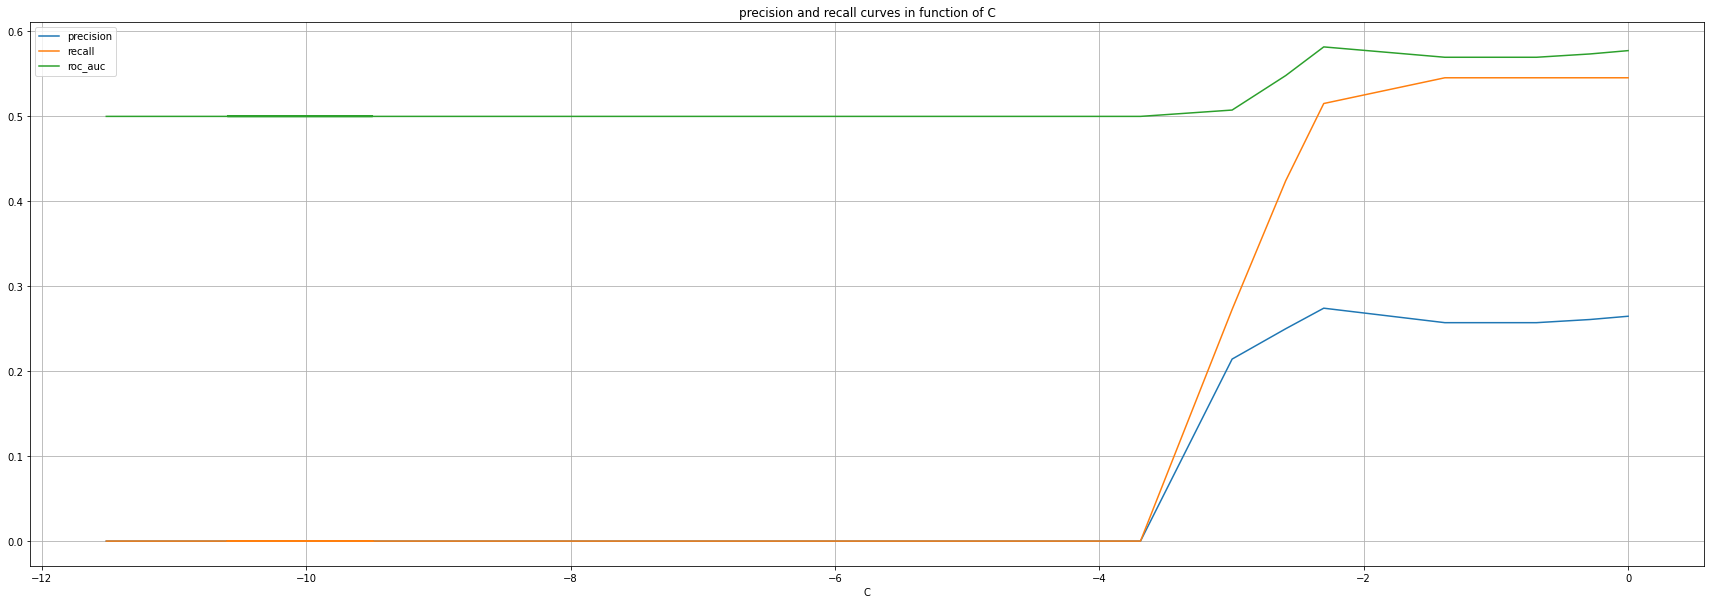

In [38]:
precision_bag = []
recall_bag = []
roc_auc_bag = []
list_to_check = [0.00001,0.000075, 0.00005, 0.000025, 0.0001,0.00025, 0.0005,0.00075, 0.001, 0.0025,
                 0.005, 0.0075, 0.01,0.025, 0.05, 0.075, 0.1,0.25, 0.5,0.75,1]
ticks = [np.log(j) for j in list_to_check]

for i in list_to_check:
    classifier = SVC(class_weight='balanced', degree=1, gamma=0.01,
                     kernel='sigmoid', C=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'C') 

print(f'precisions:{precision_bag}')
print(f'recalls:{recall_bag}')
print(f'roc_aucs:{roc_auc_bag}')



precisions:[0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.20496894409937888, 0.2222222222222222, 0.25806451612903225, 0.2465753424657534, 0.2465753424657534, 0.2537313432835821, 0.1797752808988764, 0.1702127659574468, 0.16304347826086957, 0.17894736842105263]
recalls:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7878787878787878, 0.48484848484848486, 0.5454545454545454, 0.5454545454545454, 0.5151515151515151, 0.48484848484848486, 0.48484848484848486, 0.45454545454545453, 0.5151515151515151]
roc_aucs:[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5384706439393939, 0.5627367424242424, 0.5578835227272727, 0.5578835227272727, 0.5622632575757576, 0.45726799242424243, 0.43773674242424243, 0.4264914772727273, 0.45288825757575757]


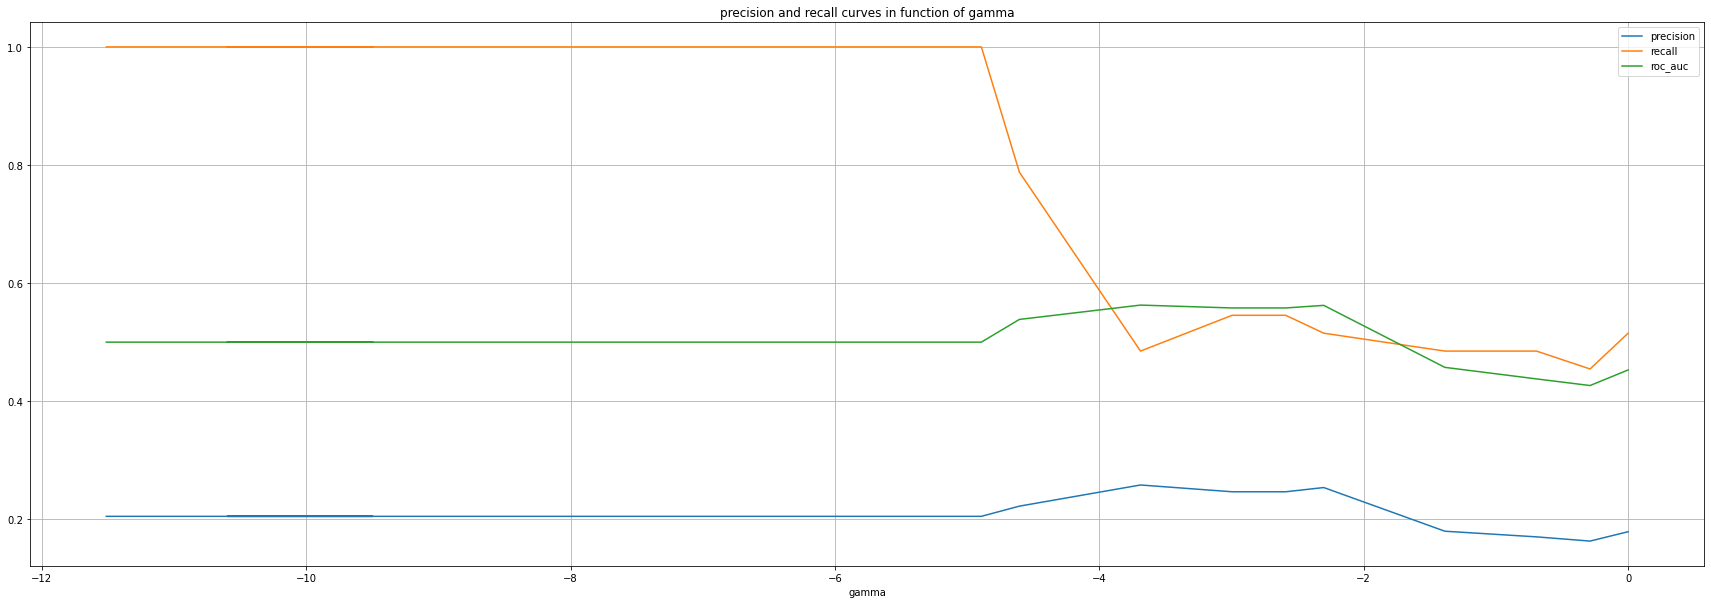

In [39]:
precision_bag = []
recall_bag = []
roc_auc_bag = []
list_to_check = [0.00001,0.000075, 0.00005, 0.000025, 0.0001,0.00025, 0.0005,0.00075, 0.001, 0.0025,
                 0.005, 0.0075, 0.01,0.025, 0.05, 0.075, 0.1,0.25, 0.5,0.75,1]

ticks = [np.log(j) for j in list_to_check]

for i in list_to_check:
    classifier = SVC(class_weight='balanced', degree=1, gamma=i,
                     kernel='sigmoid', C=10**-1.5)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'gamma') 

print(f'precisions:{precision_bag}')
print(f'recalls:{recall_bag}')
print(f'roc_aucs:{roc_auc_bag}')

precisions:[0.20496894409937888, 0.20496894409937888, 0.20496894409937888]
recalls:[1.0, 1.0, 1.0]
roc_aucs:[0.5, 0.5, 0.5]


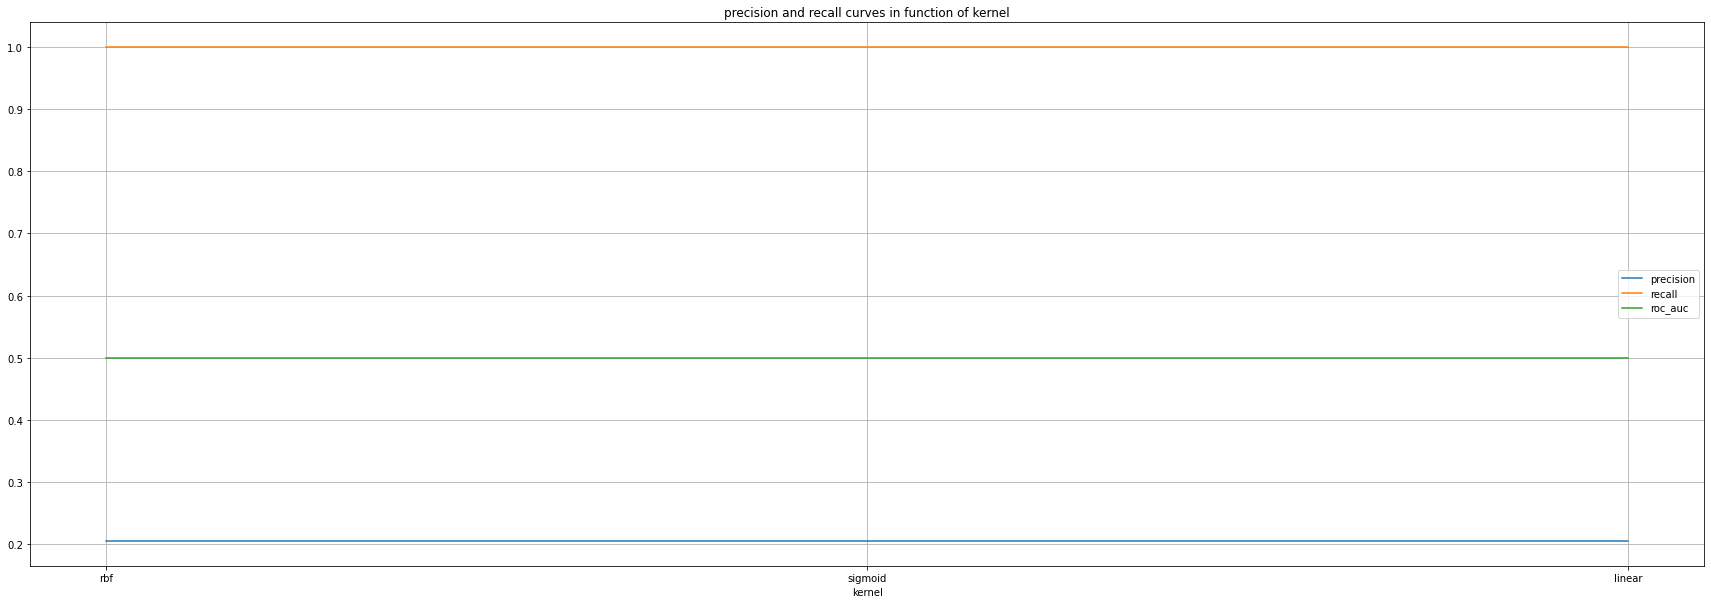

In [40]:
precision_bag = []
recall_bag = []
roc_auc_bag = []
list_to_check = ['rbf','sigmoid','linear']

for i in list_to_check:
    classifier = SVC(class_weight='balanced', degree=1, gamma=10**-6,
                     kernel='sigmoid', C=10**-1.5)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, list_to_check, 'kernel') 

print(f'precisions:{precision_bag}')
print(f'recalls:{recall_bag}')
print(f'roc_aucs:{roc_auc_bag}')


In [41]:
classifier = SVC(class_weight='balanced', degree=1, gamma=10**-6,
                     kernel='sigmoid', C=10**-1.5)

classifier, recall, precision, roc_auc = calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val)
recall_model_comparison = recall_model_comparison.append({'classifier':classifier,'recall':recall,
                                                                'roc_auc': roc_auc,
                                                                'precision':precision}, ignore_index=True)
recall_model_comparison

classifier    recall  precision  \
0  LogisticRegression(C=0.25, class_weight='balan...  0.606061   0.350877   
1  SVC(C=0.03162277660168379, class_weight='balan...  1.000000   0.204969   

    roc_auc  
0  0.658499  
1  0.500000

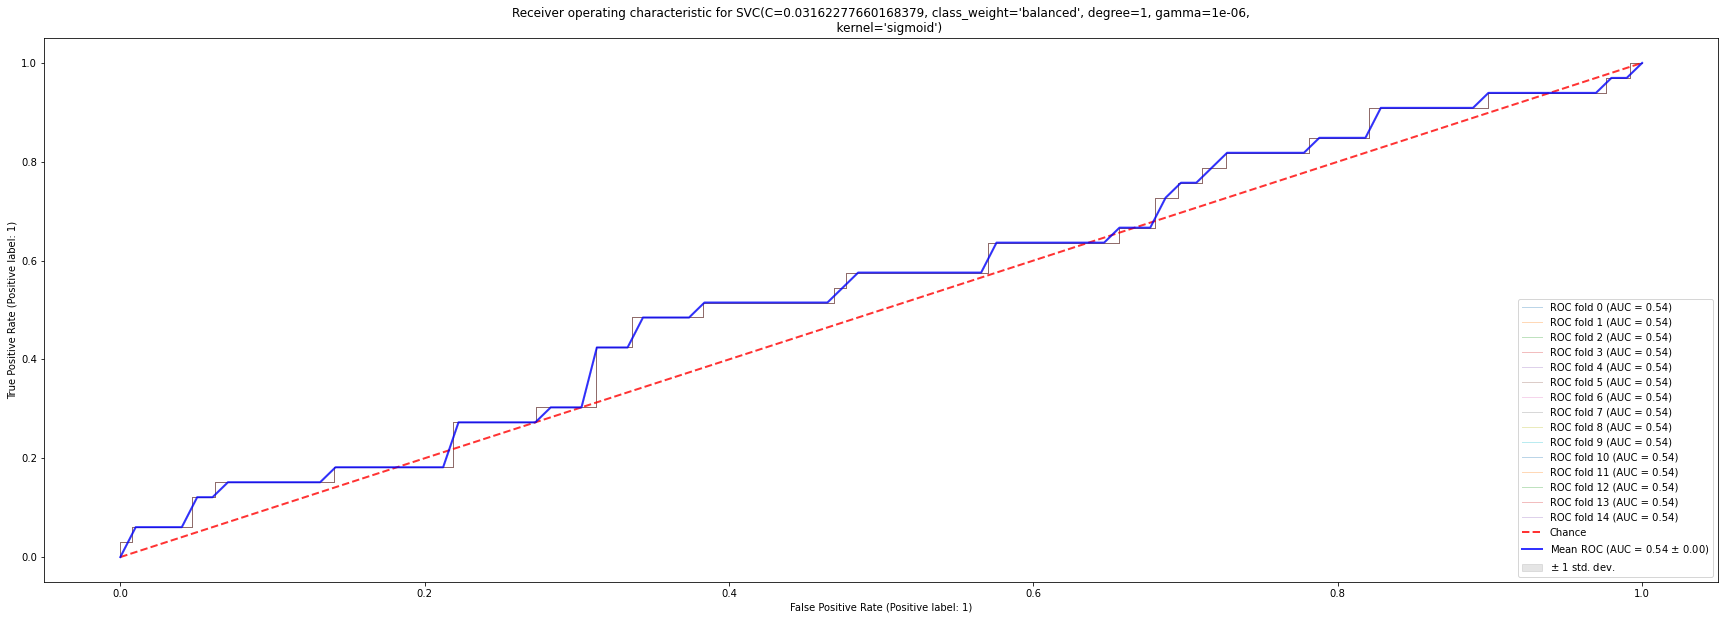

In [42]:
# roc auc curve from SKLEARN documentation
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

SV = SVC(class_weight='balanced', degree=1, gamma=10**-6,
                     kernel='sigmoid', C=10**-1.5)
LR = LogisticRegression(C=0.25, class_weight='balanced',
                                    penalty='l1', solver='liblinear')

classifier_list = [LR, SV]
X_train_k_best = [X_train, X_train]
y_train_both = [y_train, y_train]
y_val_both = [y_val, y_val]
X_val_k_best = [X_val, X_val]

for classifier, X_train, y_train, X_val, y_val in zip(classifier_list, X_train_k_best,y_train_both, X_val_k_best,y_val_both ):
    model = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])
    model.fit(X_train, y_train)

    # Run classifier with cross-validation and plot ROC curves
    # model is better than chance, but still far from optimal

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, val) in enumerate(cv.split(X, y)):
        model.fit(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            model,
            X_val,
            y_val,
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"Receiver operating characteristic for {classifier}",
    )
    ax.legend(loc="lower right")
    plt.show()


In [43]:
# Our best classifier by recall score is SV 

classifier = SV

model_recall_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])
model_recall_oriented.fit(X_train, y_train)
y_pred = model_recall_oriented.predict(X_val)
recall = recall_score(y_val.values, y_pred)
precision = precision_score(y_val.values, y_pred)
roc_auc = roc_auc_score(y_val.values, y_pred)
print(f'recall is {recall}')
print(f'precision is {precision}')
print(f'roc_auc is {roc_auc}')
result = classification_report(y_val, y_pred)
print('------------------------------------------')
print(result)

recall is 1.0
precision is 0.20496894409937888
roc_auc is 0.5
------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.20      1.00      0.34        33

    accuracy                           0.20       161
   macro avg       0.10      0.50      0.17       161
weighted avg       0.04      0.20      0.07       161



In [44]:
# We will save the model with use of pickle in order to be able 
# to use it as a helper model in another notebooks on same dataset

import pickle
# from pathlib import Path
model_recall_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])
pickle.dump(model_recall_oriented, open('model_recall_oriented.pkl', 'wb'))

# load the model from disk
recall_oriented_model = pickle.load(open('model_recall_oriented.pkl', 'rb'))
from sklearn.metrics import classification_report
y_pred=recall_oriented_model.predict(X_test)
result_recall = classification_report(y_test, y_pred)
print(result)
recall_rom = recall_score(y_test, y_pred)
precision_rom = precision_score(y_test, y_pred)
roc_auc_rom = roc_auc_score(y_test, y_pred)



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.20      1.00      0.34        33

    accuracy                           0.20       161
   macro avg       0.10      0.50      0.17       161
weighted avg       0.04      0.20      0.07       161



In [45]:
# Now we will develop another model that will be more precision oriented; we will also use it as a helper model for 
# another regression problem 



classifiers = [RandomForestClassifier(),
               DecisionTreeClassifier(),
               AdaBoostClassifier(base_estimator=LogisticRegression()),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               ExtraTreesClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    BernoulliNB(),
    SVC(), 
               RandomForestClassifier(class_weight="balanced"),
               DecisionTreeClassifier(class_weight="balanced"),
               ExtraTreesClassifier(class_weight="balanced"),
    LogisticRegression(class_weight="balanced"),
    XGBClassifier(class_weight="balanced"),
    SVC(class_weight="balanced")
              ]

first_comparison_by_precision = compare_models(classifiers, X_train, y_train, 'precision')
first_comparison_by_precision

# we want the best possible precision, but we also need the model to identify at least a small part of 1 values;
# we will focus on AdaBoost and we will try making Logistic Regression its base estimator

# AdaBoost classifier has smaller precision, but 2-3 times higher recall,
# we will grid search for its best hyperparameters

features used: Index(['avg_course_day', 'work_hours', 'mean_steps', 'weekday_sin',
       'weekday_cos', 'part_of_month_2', 'part_of_month_3', 'q_sin', 'q_cos',
       'month_sin', 'month_cos', 'wok_sin', 'wok_cos', 'job_2', 'job_3', 'R',
       'learningDS', 'homeoffice', 'Netflix', 'journey', 'holiday', 'covid',
       'dbscan_0', 'dbscan_1', 'dbscan_2', 'dbscan_3', 'dbscan_4', 'dbscan_5'],
      dtype='object')


name    recall   roc_auc  \
11                                              SVC()  0.052890  0.659110   
6                                LogisticRegression()  0.090683  0.637222   
2   AdaBoostClassifier(base_estimator=LogisticRegr...  0.077988  0.631648   
10                                      BernoulliNB()  0.039707  0.620789   
12    RandomForestClassifier(class_weight='balanced')  0.153585  0.680435   
0                            RandomForestClassifier()  0.171110  0.676682   
4                        GradientBoostingClassifier()  0.154878  0.664053   
9                                        GaussianNB()  0.210646  0.634161   
5                              ExtraTreesClassifier()  0.214171  0.675105   
7   XGBClassifier(base_score=None, booster=None, c...  0.224427  0.665850   
16  XGBClassifier(base_score=None, booster=None, c...  0.219244  0.672897   
3                                AdaBoostClassifier()  0.175976  0.625744   
8                              KNeighborsClassifier()  0.180512  0.662565   
14      ExtraTreesClassifier(class_weight='balanced')  0.204354  0.677758   
1                            DecisionTreeClassifier()  0.347061  0.579247   
17                       SVC(class_weight='balanced')  0.581207  0.686170   
13    DecisionTreeClassifier(class_weight='balanced')  0.317915  0.570753   
15        LogisticRegression(class_weight='balanced')  0.558793  0.633379   

    precision  accuracy  
11   0.661595  0.797259  
6    0.618759  0.797970  
2    0.543432  0.795431  
10   0.445643  0.791675  
12   0.407636  0.778680  
0    0.397118  0.773198  
4    0.390118  0.775838  
9    0.381072  0.762538  
5    0.375404  0.760711  
7    0.374062  0.761218  
16   0.371200  0.760000  
3    0.370824  0.767411  
8    0.369438  0.765381  
14   0.369113  0.762030  
1    0.324408  0.715127  
17   0.323069  0.661421  
13   0.318319  0.718579  
15   0.279574  0.608223

In [46]:
# default:
# (learning_rate=0.1, n_estimators=100, min_samples_split=2, max_features=None)

classifier = AdaBoostClassifier()

model_precision_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])

parameters = { 'classifier__base_estimator': [LogisticRegression()],
              'classifier__n_estimators':[100,1000, 10000],
    'classifier__learning_rate':[0.0001,0.001, 0.01, 0.1, 1]
             }

scoring = {'recall':'recall','roc_auc':'roc_auc','precision': 'precision'}
clf = GridSearchCV(model_precision_oriented,parameters, verbose=0,scoring=scoring,n_jobs=-1, cv=cv, refit='precision', return_train_score=True)
clf.fit(X_train,y_train)
results = clf.cv_results_
best_index = clf.best_index_
best_estimator = clf.best_estimator_
roc_auc = clf.cv_results_['mean_train_roc_auc'][best_index]
recall = clf.cv_results_['mean_train_recall'][best_index]
print("Results from Grid Search" )
print(f'\n The best estimator across ALL searched params: {best_estimator}')
print('-----------------------------------------------------------')
print("\n The best precision score across ALL searched params:\n",clf.best_score_)
print(f'roc_auc is: {roc_auc}')
print(f'recall is: {recall}')

# best estimator is: AdaBoostClassifier(base_estimator=LogisticRegression(),
#                                     learning_rate=0.001, n_estimators=10000)

Results from Grid Search

 The best estimator across ALL searched params: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('classifier',
                 AdaBoostClassifier(base_estimator=LogisticRegression(),
                                    learning_rate=0.001, n_estimators=10000))])
-----------------------------------------------------------

 The best precision score across ALL searched params:
 0.7266666666666666
roc_auc is: 0.6836823388531432
recall is: 0.06043942341263904


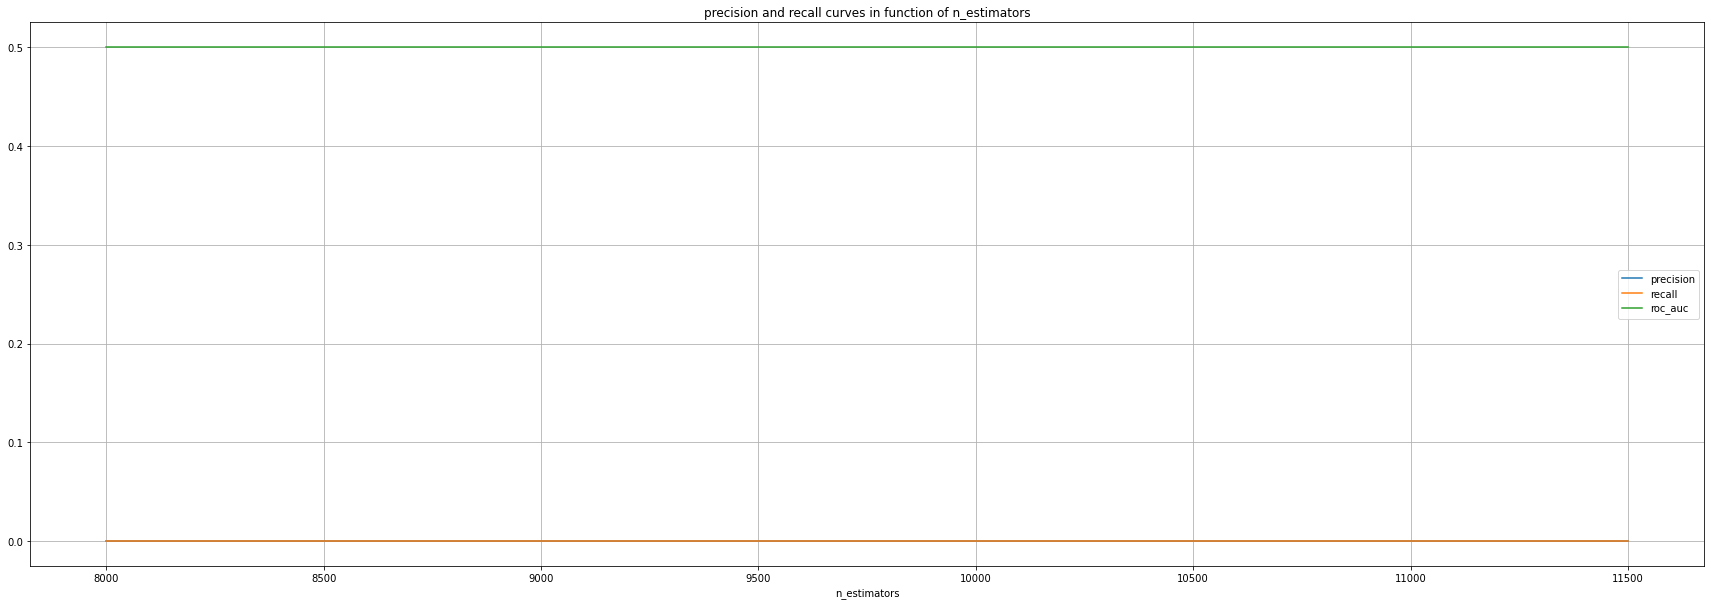

In [47]:
# we plot recall and precision scores for n_estimators and numbers between to see if we can find
# a better fit with the lower learning rate and n_estimators chosen by grid search
# learning rate of 0.0001 seems to low, as the model was not able to detect any 1 values, even with high n_estimators;
# we discart lower learning rate 


precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(8000,12000,500)]

for i in np.arange(8000,12000,500):
    classifier = AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.0001, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

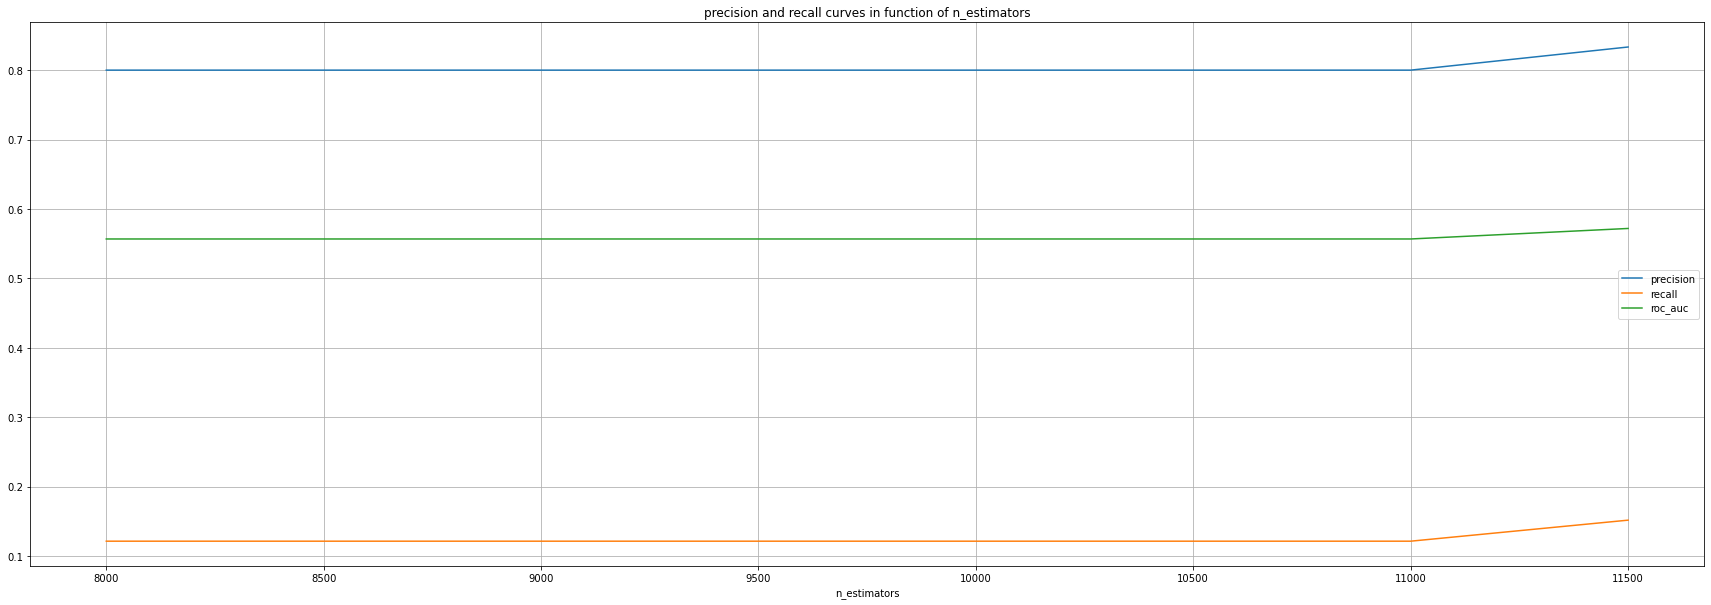

In [48]:
# Precision is below 1, which is not meeting our objective of 1 precision; we discart the option of higher learning rate

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(8000,12000,500)]

for i in np.arange(8000,12000,500):
    classifier = AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.01, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

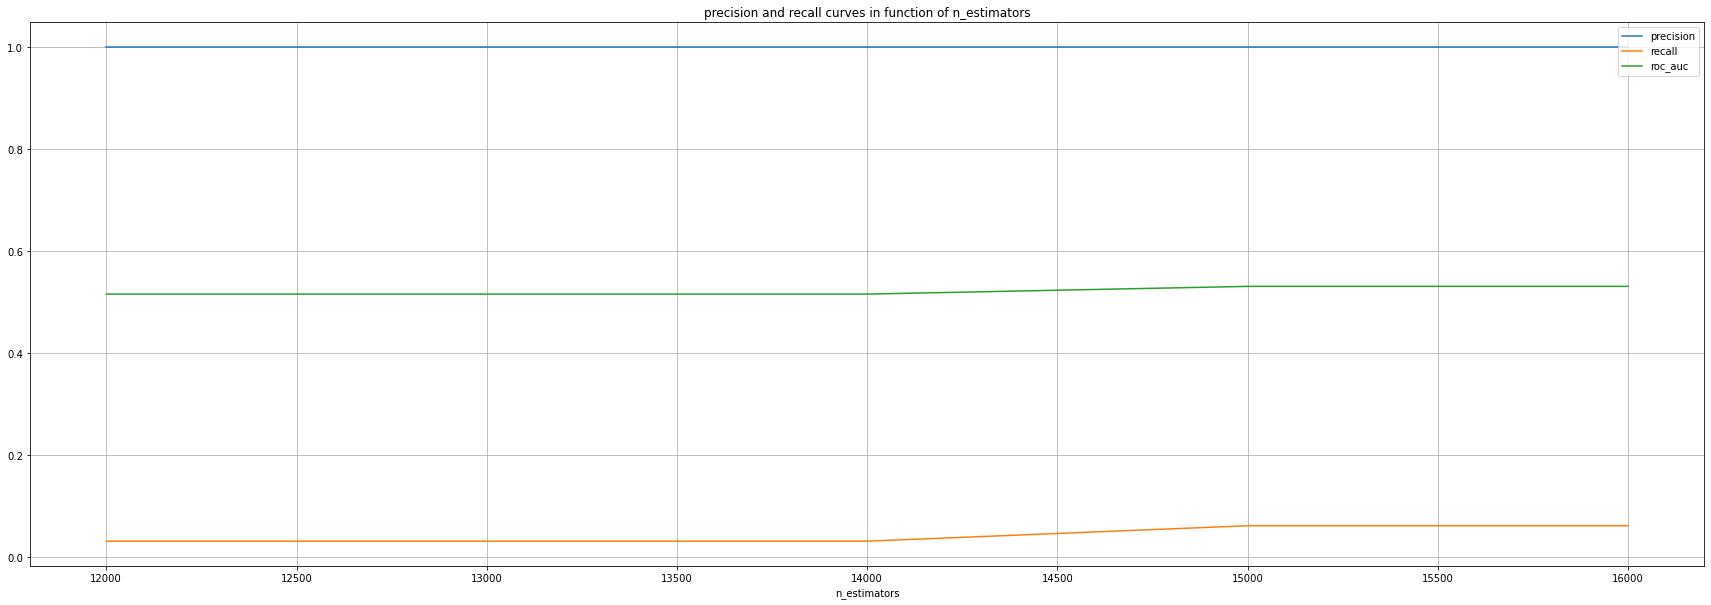

In [49]:
# We check if higher number of n_estimators gives better results
precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(12000,17000,1000)]

for i in np.arange(12000,17000,1000):
    classifier = AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.001, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

In [50]:
# we are creating a dataframe to save all scores to be able to compare them later on

precision_model_comparison = pd.DataFrame(columns = ['classifier', 'recall', 'roc_auc','precision' ])

classifier = AdaBoostClassifier(base_estimator=LogisticRegression(),
                                    learning_rate=0.001, n_estimators=17000)

def calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val):
    model_precision_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])
    model_precision_oriented.fit(X_train, y_train)
    y_pred = model_precision_oriented.predict(X_val)
    recall = recall_score(y_val.values, y_pred)
    precision = precision_score(y_val.values, y_pred)
    roc_auc = roc_auc_score(y_val.values, y_pred)
    return classifier, recall, precision, roc_auc

classifier, recall, precision, roc_auc = calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val)
precision_model_comparison = precision_model_comparison.append({'classifier':classifier,'recall':recall, 
                                                                'roc_auc': roc_auc, 'precision':precision},
                                                               ignore_index=True)

In [51]:
precision_model_comparison

classifier    recall   roc_auc  \
0  (LogisticRegression(random_state=1864167934), ...  0.121212  0.560606   

   precision  
0        1.0

In [52]:
# We will check if we can tune XGBoost to have better performance than AdaBoost
# default hyperparameters:
# (n_estimators=1000, min_samples_split=2, max_features=None)
# as the recall value for default hyperparameters seems high for a dataset made manually(prone to mistakes), 
# we will grid search also for some hyperparameters that help with overfitting(max_depth, min_samples_split)

classifier = XGBClassifier(class_weight='balanced')

model_precision_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])

parameters = { 'classifier__subsample': [0.5, 0.75,1],
    'classifier__max_features': [2,'sqrt',10],
              'classifier__max_depth':[2,3,5],
#               'classifier__min_samples_split':[2, 15, 25],
              'classifier__n_estimators':[100,1000,10000],
    'classifier__learning_rate':[0.001,0.1, 1],
              
             }

scoring = {'recall':'recall','roc_auc':'roc_auc','precision': 'precision'}
clf = GridSearchCV(model_precision_oriented,parameters, verbose=5,scoring=scoring,n_jobs=-1, cv=cv, refit='precision', return_train_score=True)
clf.fit(X_train,y_train)
results = clf.cv_results_
best_index = clf.best_index_
best_estimator = clf.best_estimator_
roc_auc = clf.cv_results_['mean_train_roc_auc'][best_index]
recall = clf.cv_results_['mean_train_recall'][best_index]
print("Results from Grid Search" )
print(f'\n The best estimator across ALL searched params: {best_estimator}')
print('-----------------------------------------------------------')
print("\n The best roc_auc score across ALL searched params:\n",clf.best_score_)
print(f'recall is: {recall}')
print(f'precision is: {roc_auc}')

Fitting 15 folds for each of 243 candidates, totalling 3645 fits
[19:49:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "max_features" } are not used.

Results from Grid Search

 The best estimator across ALL searched params: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight='balanced', colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                 

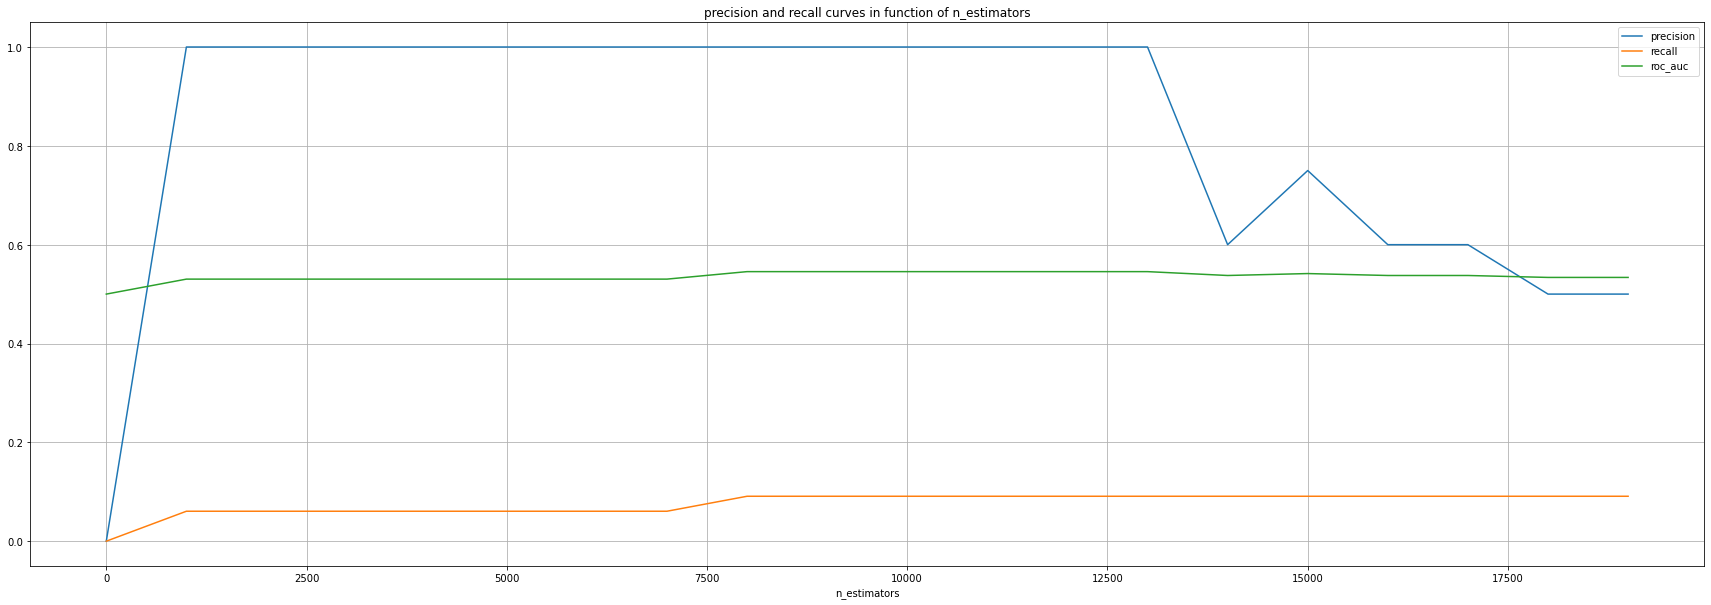

In [77]:
#Plotting recall and precision for n_estimators from 0 to 20000 for ;
# precision is below 1,so we discart option of more than 10000 estimators for learning rate of 10000

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(0,20000,1000)]

for i in np.arange(0,20000,1000):
    classifier = XGBClassifier(learning_rate=0.001, max_depth=2, max_features=5, verbosity = 0, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

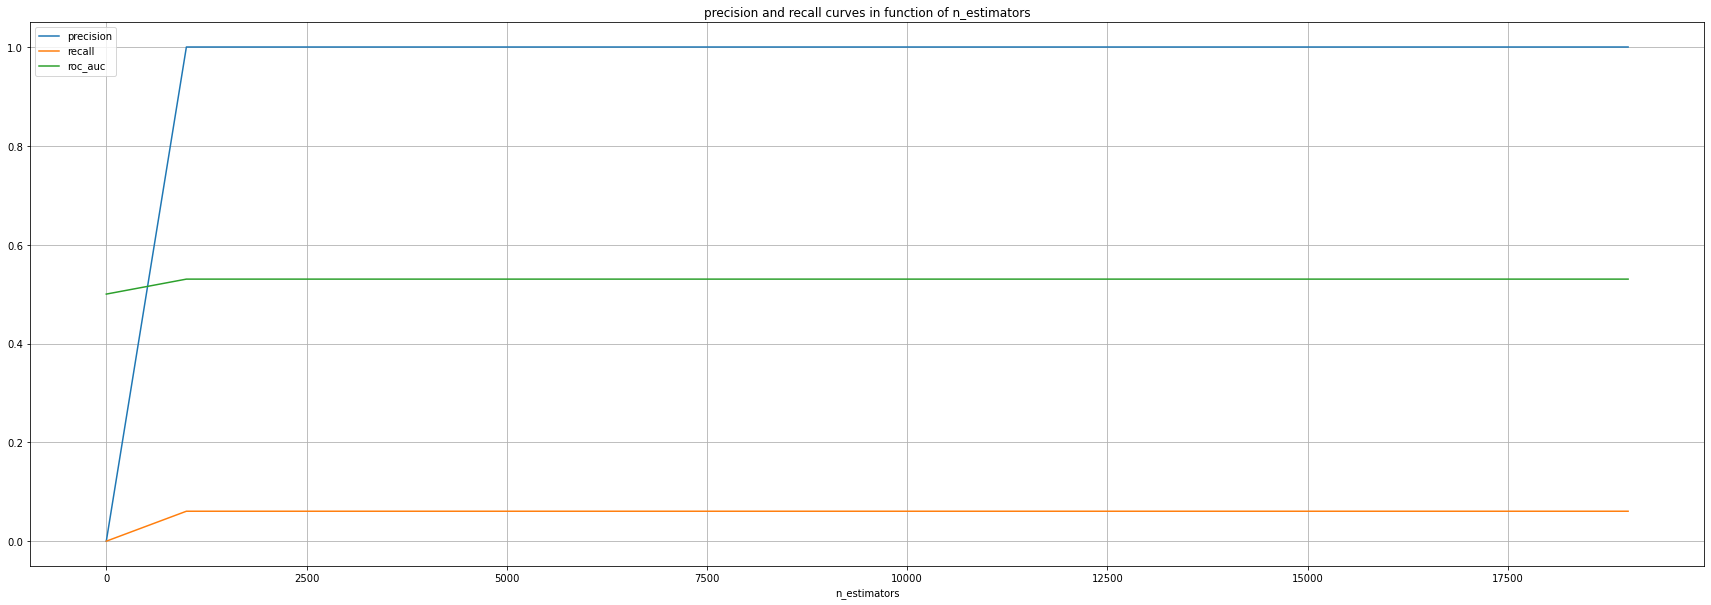

In [78]:
# We discart learning rate of 0.0001, as it makes the precision to low

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(0,20000,1000)]

for i in np.arange(0,20000,1000):
    classifier = XGBClassifier(learning_rate=0.0001, max_depth=2, max_features=5, verbosity = 0, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

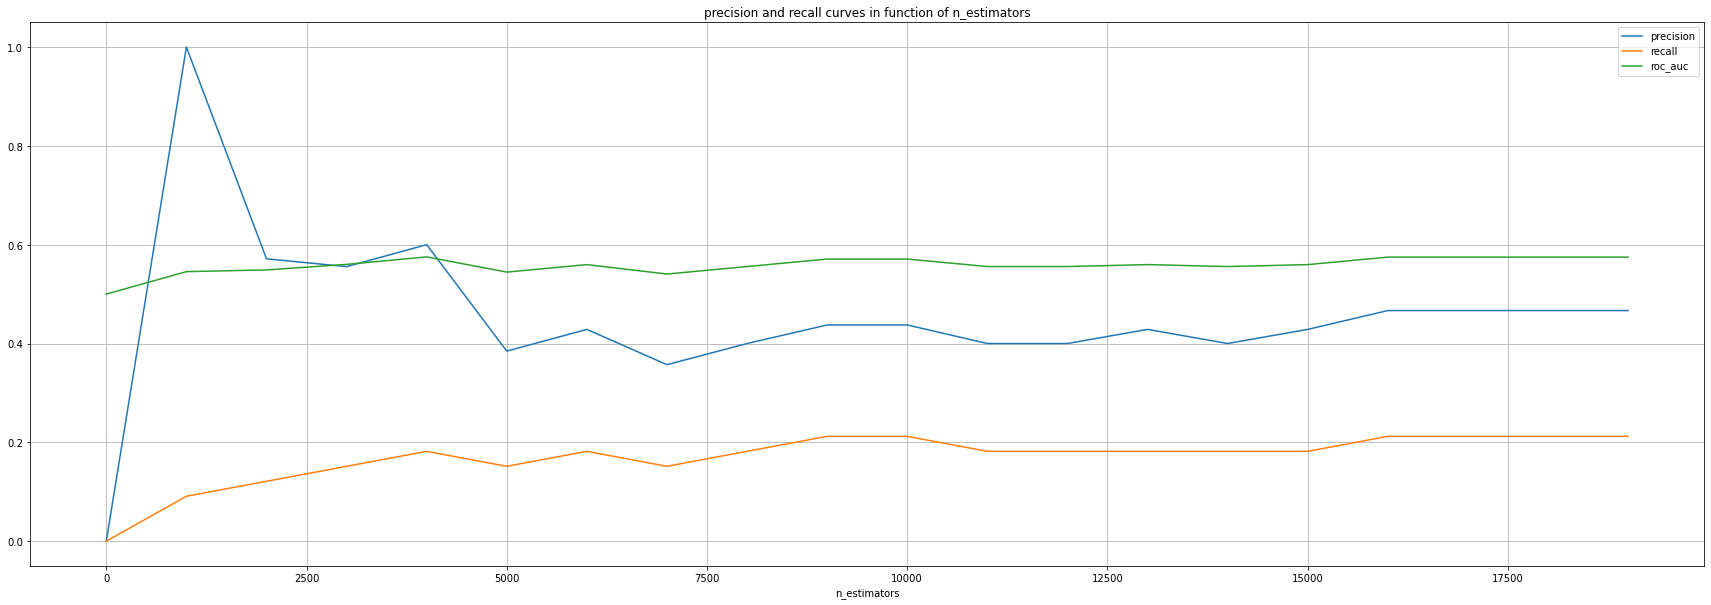

In [79]:
# As n_estimators in Gridsearch is very limited, 
# we will plot validation curves for a wide range of n_estimators to find optimal value

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(0,20000,1000)]

for i in np.arange(0,20000,1000):
    classifier = XGBClassifier(learning_rate=0.01, max_depth=2, max_features=5, verbosity = 0, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

In [80]:
# Evaluation on validation set  with chosen hyperparameters 

classifier = XGBClassifier(learning_rate=0.001, max_depth=2, max_features=5, verbosity = 0, n_estimators=8500)

classifier, recall, precision, roc_auc = calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val)
precision_model_comparison = precision_model_comparison.append({'classifier':classifier,'recall':recall,
                                                                'roc_auc': roc_auc,
                                                                'precision':precision}, ignore_index=True)
precision_model_comparison

classifier    recall   roc_auc  \
0  (LogisticRegression(random_state=1864167934), ...  0.121212  0.560606   
1  XGBClassifier(base_score=None, booster=None, c...  0.090909  0.545455   

   precision  
0        1.0  
1        1.0

In [81]:
#Our best precision oriented model is AdaBoost with base estimator Logistic Regression ; 
# We will save the model with use of pickle in order to be able to use it as a helper model in another notebooks 
#  applied to the same dataset

classifier = AdaBoostClassifier(base_estimator=LogisticRegression(),
                                    learning_rate=0.001, n_estimators=17000)
model_precision_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])
model_precision_oriented.fit(X_train, y_train)
pickle.dump(model_precision_oriented, open('model_precision_oriented.pkl', 'wb'))
precision_oriented_model = pickle.load(open('model_precision_oriented.pkl', 'rb'))
y_pred=precision_oriented_model.predict(X_test)
result_precision = classification_report(y_test, y_pred)
print(result)
recall_pom = recall_score(y_test, y_pred)
precision_pom = precision_score(y_test, y_pred)
roc_auc_pom = roc_auc_score(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.20      1.00      0.34        33

    accuracy                           0.20       161
   macro avg       0.10      0.50      0.17       161
weighted avg       0.04      0.20      0.07       161



In [82]:
# Now we will develop another model that will be roc_auc oriented;


classifiers = [RandomForestClassifier(),
               DecisionTreeClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               ExtraTreesClassifier(),
    LogisticRegression(),
    XGBClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    BernoulliNB(),
    SVC(), 
               RandomForestClassifier(class_weight="balanced"),
               DecisionTreeClassifier(class_weight="balanced"),
               ExtraTreesClassifier(class_weight="balanced"),
    LogisticRegression(class_weight="balanced"),
    XGBClassifier(class_weight="balanced"),
    SVC(class_weight="balanced")
              ]

first_comparison_by_roc_auc = compare_models(classifiers, X_train, y_train, 'roc_auc')
first_comparison_by_roc_auc

features used: Index(['avg_course_day', 'work_hours', 'mean_steps', 'weekday_sin',
       'weekday_cos', 'part_of_month_2', 'part_of_month_3', 'q_sin', 'q_cos',
       'month_sin', 'month_cos', 'wok_sin', 'wok_cos', 'job_2', 'job_3', 'R',
       'learningDS', 'homeoffice', 'Netflix', 'journey', 'holiday', 'covid',
       'dbscan_0', 'dbscan_1', 'dbscan_2', 'dbscan_3', 'dbscan_4', 'dbscan_5'],
      dtype='object')


name    recall   roc_auc  \
11    RandomForestClassifier(class_weight='balanced')  0.156427  0.685956   
16                       SVC(class_weight='balanced')  0.573463  0.684419   
6   XGBClassifier(base_score=None, booster=None, c...  0.231354  0.683883   
0                            RandomForestClassifier()  0.177463  0.679693   
13      ExtraTreesClassifier(class_weight='balanced')  0.203500  0.677334   
4                              ExtraTreesClassifier()  0.226963  0.672760   
15  XGBClassifier(base_score=None, booster=None, c...  0.217220  0.668555   
3                        GradientBoostingClassifier()  0.160805  0.667192   
10                                              SVC()  0.046524  0.663375   
7                              KNeighborsClassifier()  0.183976  0.660098   
8                                        GaussianNB()  0.211988  0.640105   
5                                LogisticRegression()  0.089683  0.639662   
2                                AdaBoostClassifier()  0.193073  0.636815   
14        LogisticRegression(class_weight='balanced')  0.557390  0.635358   
9                                       BernoulliNB()  0.045549  0.622541   
1                            DecisionTreeClassifier()  0.332585  0.576238   
12    DecisionTreeClassifier(class_weight='balanced')  0.315524  0.569377   

    precision  accuracy  
11   0.403967  0.777766  
16   0.313109  0.651472  
6    0.362749  0.758274  
0    0.393082  0.772995  
13   0.369527  0.762640  
4    0.386202  0.765076  
15   0.359290  0.755736  
3    0.409600  0.778680  
10   0.597373  0.795736  
7    0.378130  0.766701  
8    0.376099  0.763147  
5    0.609689  0.797157  
2    0.378647  0.768528  
14   0.282341  0.614315  
9    0.441492  0.790761  
1    0.323216  0.717766  
12   0.319954  0.718071

In [84]:
# default params are:(*, C=1.0, kernel='rbf', gamma='scale', class_weight=None)
# we will also try clfularization parameters in our gridsearch to avoid overfitting; 

classifier = SVC(class_weight='balanced')

model = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])

parameters = { 
#     'classifier__C': [0.0001, 0.001, 0.01, 0.01, 0.5,1],
              'classifier__kernel':['rbf','sigmoid', 'gaussian', 'linear', 'polynomial'],
    'classifier__gamma':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'classifier__degree':[1,2,3]
}

scoring = {'recall':'recall','roc_auc':'roc_auc','precision': 'precision'}
clf = GridSearchCV(model,parameters, verbose=0,scoring=scoring,n_jobs=-1, cv=cv, refit='roc_auc', return_train_score=True)
clf.fit(X_train,y_train)
results = clf.cv_results_
best_index = clf.best_index_
best_estimator = clf.best_estimator_
recall = clf.cv_results_['mean_train_recall'][best_index]
precision = clf.cv_results_['mean_train_precision'][best_index]
print("Results from Grid Search" )
print(f'\n The best estimator across ALL searched params: {best_estimator}')
print('-----------------------------------------------------------')
print('\n The best roc_auc score across ALL searched params:\n',clf.best_score_)
print(f'recall is: {recall}')
print(f'precision is: {precision}')


Results from Grid Search

 The best estimator across ALL searched params: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('classifier',
                 SVC(class_weight='balanced', degree=1, gamma=0.1))])
-----------------------------------------------------------

 The best roc_auc score across ALL searched params:
 0.6954830845711691
recall is: 0.9166791361165145
precision is: 0.5399722416765175


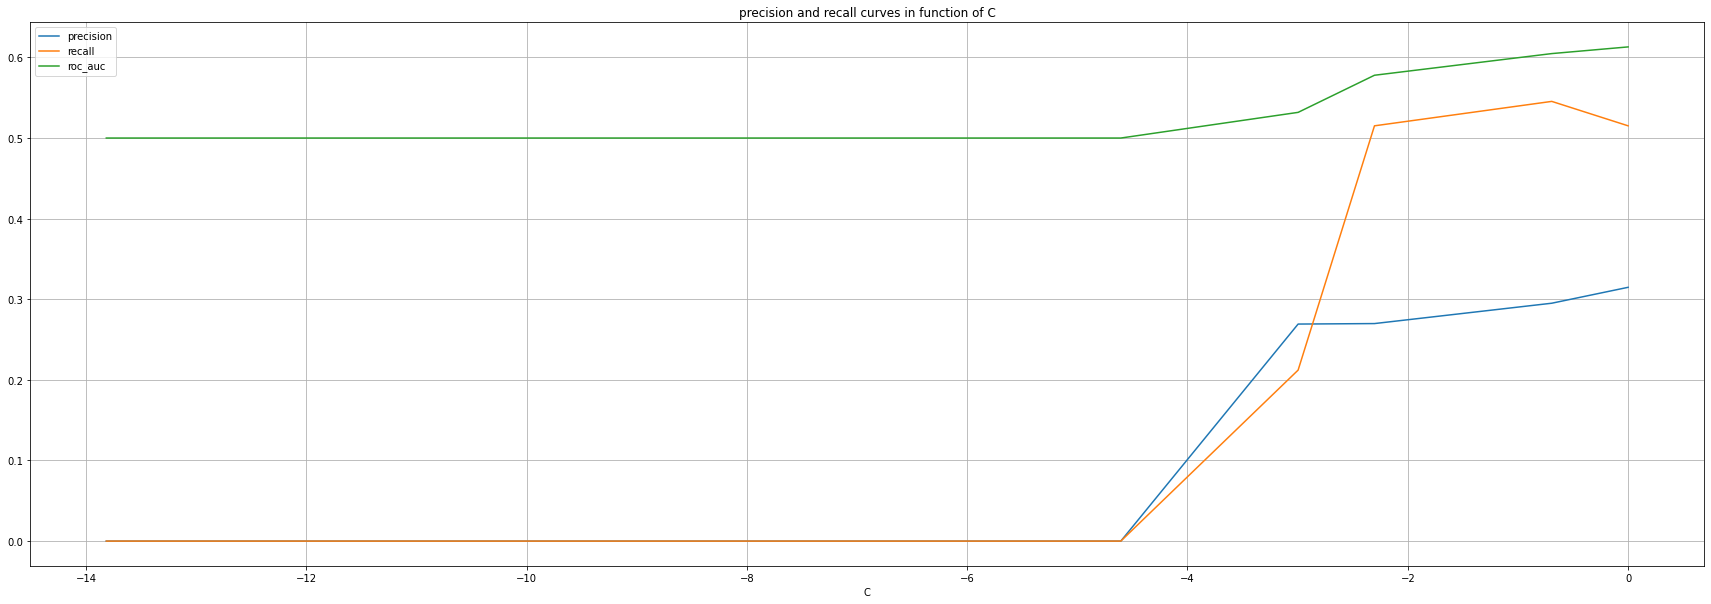

In [85]:
# Tuning C with validation curves
precision_bag = []
recall_bag = []
roc_auc_bag = []
list_to_check = [0.000001,0.000005, 0.00001, 0.00005, 0.0001,0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1]
ticks = [np.log(j) for j in list_to_check]

for i in list_to_check:
    classifier = SVC(C=i, class_weight='balanced', degree=1, gamma=0.1)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'C') 

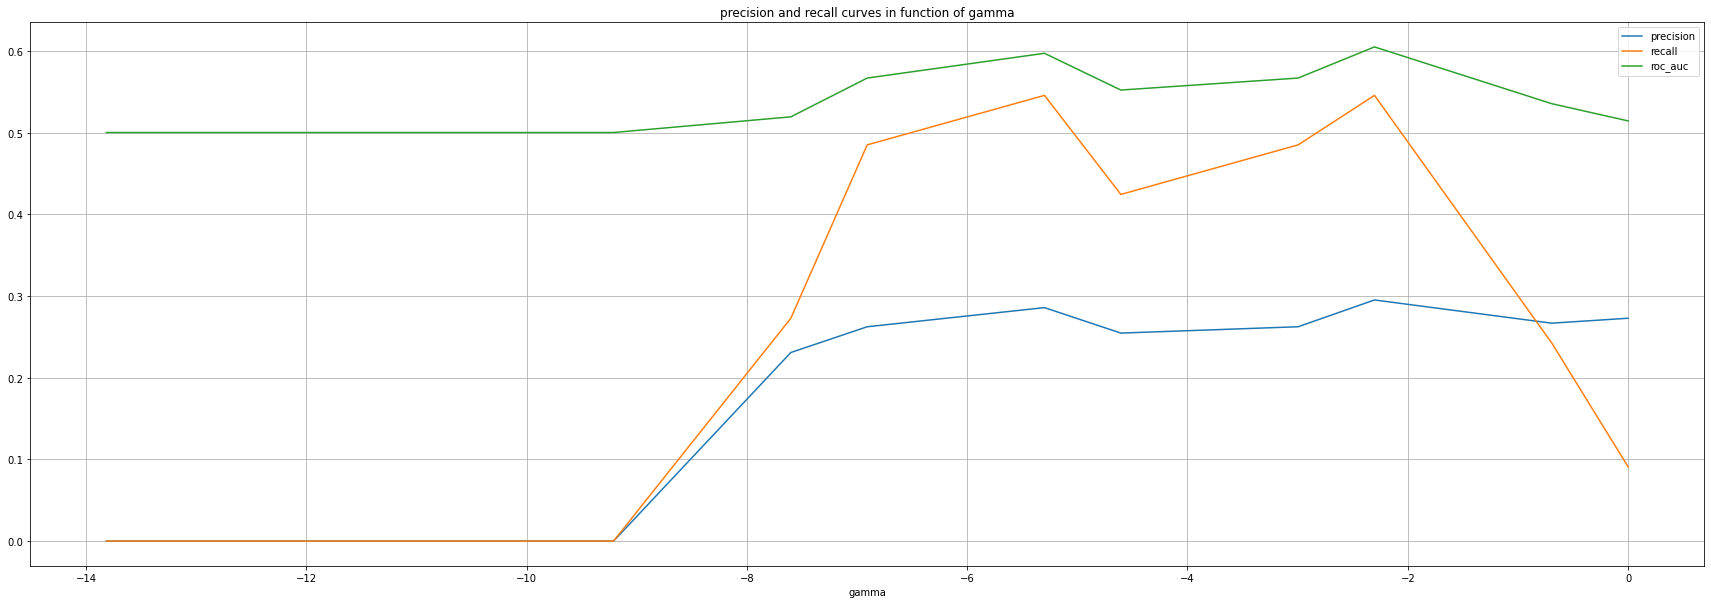

In [86]:
# Tuning gamma with validation curves
precision_bag = []
recall_bag = []
roc_auc_bag = []
list_to_check = [0.000001,0.000005, 0.00001, 0.00005, 0.0001,0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1]
ticks = [np.log(j) for j in list_to_check]

for i in list_to_check:
    classifier = SVC(C=0.5, class_weight='balanced', degree=1, gamma=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'gamma') 

In [87]:
# Our best params for SVC are: classifier = SVC(C=0.5, class_weight='balanced', degree=1, gamma=0.005)

roc_auc_model_comparison = pd.DataFrame(columns=['classifier', 'recall', 'roc_auc', 'precision'])

classifier = SVC(C=0.5, class_weight='balanced', degree=1, gamma=0.005)

classifier, recall, precision, roc_auc = calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val)
roc_auc_model_comparison = roc_auc_model_comparison.append({'classifier':classifier,'recall':recall,
                                                                'roc_auc': roc_auc,
                                                                'precision':precision}, ignore_index=True)
roc_auc_model_comparison

classifier    recall   roc_auc  \
0  SVC(C=0.5, class_weight='balanced', degree=1, ...  0.545455  0.596946   

   precision  
0   0.285714

In [88]:
# We will check if we can tune XGBoost to have better performance than SVC
# default:
# (n_estimators=1000, min_samples_split=2, max_features=None)
# we will grid search also for some hyperparameters that help with overfitting(max_depth, min_samples_split)

classifier = XGBClassifier(class_weight='balanced')

model_roc_auc_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])

parameters = { 
#     'classifier__subsample': [0.5, 0.75,1],
    'classifier__max_features': [2,'sqrt'],
              'classifier__max_depth':[2,3,5],
#               'classifier__min_samples_split':[2, 15, 25],
              'classifier__n_estimators':[100,1000,10000],
    'classifier__learning_rate':[0.0001,0.01, 0.1, 1],
              
             }

scoring = {'recall':'recall','roc_auc':'roc_auc','precision': 'precision'}
clf = GridSearchCV(model_roc_auc_oriented,parameters, verbose=5,scoring=scoring,n_jobs=-1, cv=cv, refit='roc_auc', return_train_score=True)
clf.fit(X_train,y_train)
results = clf.cv_results_
best_index = clf.best_index_
best_estimator = clf.best_estimator_
roc_auc = clf.cv_results_['mean_train_roc_auc'][best_index]
recall = clf.cv_results_['mean_train_recall'][best_index]
print("Results from Grid Search" )
print(f'\n The best estimator across ALL searched params: {best_estimator}')
print('-----------------------------------------------------------')
print("\n The best roc_auc score across ALL searched params:\n",clf.best_score_)
print(f'recall is: {recall}')
print(f'precision is: {precision}')

#  Grid search best estimator is: XGBClassifier(class_weight='balanced', learning_rate=0.01, 
# max_depth=5, max_features=2, n_estimators=1000)
# The best roc_auc score across ALL searched params:
#  0.6779197952807554
# recall is: 0.9583370741682877
# precision is: 0.2857142857142857

Fitting 15 folds for each of 72 candidates, totalling 1080 fits
[22:01:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight", "max_features" } are not used.

Results from Grid Search

 The best estimator across ALL searched params: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_weight='balanced', colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                  

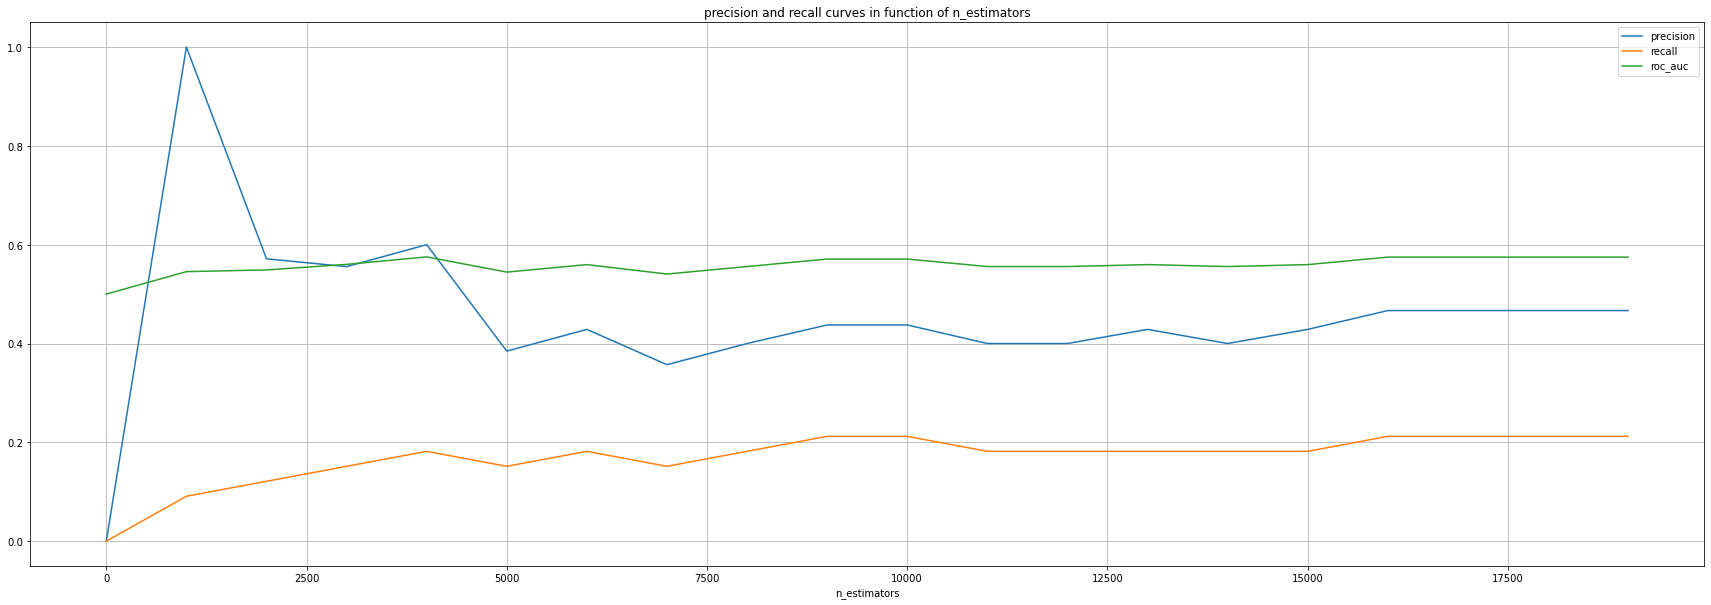

In [92]:
# Let's  plot a validation curve to find the best number of n_estimators
# Our best n_estimators is 1200; we can see that the results on the validation set are worse than on training set; 
# this might suggest overfitting;we will also limit max_features to fight that

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(0,20000,1000)]

for i in np.arange(0,20000,1000):
    classifier = XGBClassifier(learning_rate=0.01, max_depth=2, max_features=3, verbosity=0, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'n_estimators')

In [93]:
# Let's double check if we can get a better roc_auc with smaller learning rate and more n_estimators
# roc auc and recall on validation set is smaller; we discart smaller learning rate

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(0,20000,1000)]

for i in np.arange(0,20000,1000):
    classifier = XGBClassifier(learning_rate=0.001, max_depth=2, max_features=3, verbosity=0, n_estimators=i)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'learning_rate')

In [96]:
# Let's double check for higher learning rate
# roc auc and recall is smaller; we discart higher learning rate

precision_bag = []
recall_bag = []
roc_auc_bag = []
ticks = [j for j in np.arange(0,20000,1000)]

for i in np.arange(0,20000,1000):
    classifier = XGBClassifier(class_weight='balanced', learning_rate=0.05, max_depth=3, 
                               max_features=2, n_estimators=i, verbosity=0)
    precision_point, recall_point, roc_auc_point = add_precision_recall_point(X_train, y_train, X_val, y_val)
    precision_bag.append(precision_point)
    recall_bag.append(recall_point)
    roc_auc_bag.append(roc_auc_point)

plot_precision_and_recall(precision_bag, recall_bag, roc_auc_bag, ticks, 'learning_rate')

In [97]:
# Our tuned XGBoost classifier is:
classifier = XGBClassifier(class_weight='balanced', learning_rate=0.01, max_depth=3, max_features=2, 
                           n_estimators=1200, verbosity=0)

classifier, recall, precision, roc_auc = calculate_scores_for_model_comparison(classifier, X_train, y_train, X_val, y_val)
roc_auc_model_comparison = roc_auc_model_comparison.append({'classifier':classifier,'recall':recall,
                                                                'roc_auc': roc_auc,
                                                                'precision':precision}, ignore_index=True)
roc_auc_model_comparison

classifier    recall   roc_auc  \
0  SVC(C=0.5, class_weight='balanced', degree=1, ...  0.545455  0.596946   
1  XGBClassifier(base_score=None, booster=None, c...  0.090909  0.533736   

   precision  
0   0.285714  
1   0.500000

In [98]:
# XGBoost did not beat SVC in this case; Our best model is:

classifier = SVC(C=0.5, class_weight='balanced', degree=1, gamma=0.005)

model_roc_auc_oriented = Pipeline([('scaler',scaler),('pca',pca),('classifier', classifier)])

model_roc_auc_oriented.fit(X_train, y_train)
pickle.dump(model_roc_auc_oriented, open('model_roc_auc_oriented.pkl', 'wb'))
roc_auc_oriented_model = pickle.load(open('model_roc_auc_oriented.pkl', 'rb'))
from sklearn.metrics import classification_report
y_pred=roc_auc_oriented_model.predict(X_test)
result_roc_auc = classification_report(y_test, y_pred)
print(result)
roc_auc  = roc_auc_score(y_test, y_pred)
print(f'roc_auc is {roc_auc}')
recall_aom = recall_score(y_test, y_pred)
precision_aom = precision_score(y_test, y_pred)
roc_auc_aom = roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.20      1.00      0.34        33

    accuracy                           0.20       161
   macro avg       0.10      0.50      0.17       161
weighted avg       0.04      0.20      0.07       161

roc_auc is 0.608875


In [99]:
# Gathering results of validation on our final test set for all our models
print('RESULTS FOR RECALL ORIENTED MODEL')
print(result_recall)
print(f'recall_rom: {recall_rom}')
print(f'precision_rom: {precision_rom}')
print(f'roc_auc_rom: {roc_auc_rom}')
print('-----------------')
print('RESULTS FOR PRECISION ORIENTED MODEL')
print(result_precision)
print(f'recall_pom: {recall_pom}')
print(f'precision_pom: {precision_pom}')
print(f'roc_auc_pom: {roc_auc_pom}')
print('-----------------')
print('RESULTS FOR ROC_AUC ORIENTED MODEL')
print(result_roc_auc)
print(f'recall_aom: {recall_aom}')
print(f'precision_aom: {precision_aom}')
print(f'roc_auc_pom: {roc_auc_aom}')
print('-----------------')

RESULTS FOR RECALL ORIENTED MODEL
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.20      1.00      0.34        32

    accuracy                           0.20       157
   macro avg       0.10      0.50      0.17       157
weighted avg       0.04      0.20      0.07       157

recall_rom: 1.0
precision_rom: 0.20382165605095542
roc_auc_rom: 0.5
-----------------
RESULTS FOR PRECISION ORIENTED MODEL
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       125
           1       1.00      0.06      0.12        32

    accuracy                           0.81       157
   macro avg       0.90      0.53      0.51       157
weighted avg       0.85      0.81      0.73       157

recall_pom: 0.0625
precision_pom: 1.0
roc_auc_pom: 0.53125
-----------------
RESULTS FOR ROC_AUC ORIENTED MODEL
              precision    recall  f1-score   support

           0       0.8

precision score is: 0.59375
recall score is: 0.2878787878787879
roc_auc score is: 0.5725108225108225
accuracy is: 0.6178343949044586
Confusion matrix:


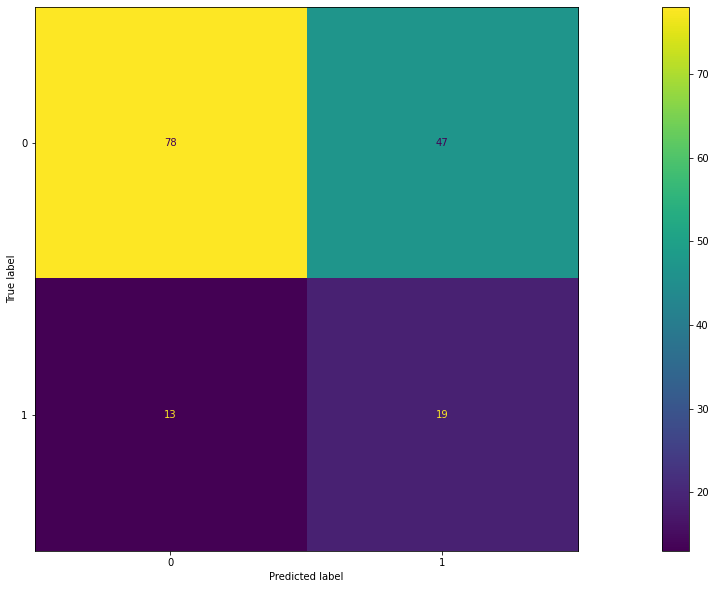

In [100]:
# Just out of curiosity, let's check performance of our 3 models combined

from sklearn.ensemble import VotingClassifier

voting_hard = VotingClassifier(estimators=[ ('recall_oriented', model_recall_oriented),
                                                 ('precision_oriented', model_precision_oriented),
                                                 ('roc_auc_oriented', model_roc_auc_oriented)], voting='hard')

voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('precision score is: ' +str(precision_score(y_pred_hard, y_test)))
print('recall score is: ' +str(recall_score(y_pred_hard, y_test)))
print('roc_auc score is: ' +str(roc_auc_score(y_pred_hard, y_test)))
print('accuracy is: ' + str(voting_hard.score(X_test, y_test)))

print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred_hard, labels=voting_hard.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
# Let's check performance of voting classifier composed of recall oriented and roc_auc oriented models

voting_hard = VotingClassifier(estimators=[ ('recall_oriented', model_recall_oriented),
                                                 ('roc_auc_oriented', model_roc_auc_oriented)], voting='hard')

voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)
print('precision score is: ' +str(precision_score(y_pred_hard, y_test)))
print('recall score is: ' +str(recall_score(y_pred_hard, y_test)))
print('roc_auc score is: ' +str(roc_auc_score(y_pred_hard, y_test)))
print('accuracy is: ' + str(voting_hard.score(X_test, y_test)))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred_hard, labels=voting_hard.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

precision score is: 0.0625
recall score is: 1.0
roc_auc score is: 0.9032258064516129
accuracy is: 0.8089171974522293
Confusion matrix:


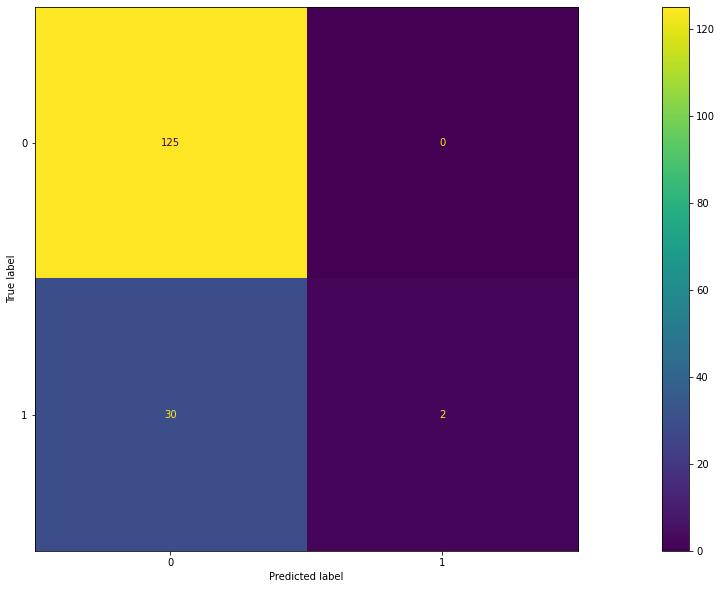

In [101]:
# Let's check performance of voting classifier composed of recall oriented and roc_auc oriented models

voting_hard = VotingClassifier(estimators=[ ('recall_oriented', model_recall_oriented),
                                                 ('precision_oriented', model_precision_oriented)], voting='hard')

voting_hard.fit(X_train, y_train)
y_pred_hard = voting_hard.predict(X_test)
print('precision score is: ' +str(precision_score(y_pred_hard, y_test)))
print('recall score is: ' +str(recall_score(y_pred_hard, y_test)))
print('roc_auc score is: ' +str(roc_auc_score(y_pred_hard, y_test)))
print('accuracy is: ' + str(voting_hard.score(X_test, y_test)))
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred_hard, labels=voting_hard.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [102]:
# We will pickle our second voting classifier, as it seems to be the best one overall if we focus on 1 detection, 
# but don't want to missclasify to many 0s.

voting_hard = VotingClassifier(estimators=[ ('recall_oriented', model_recall_oriented),
                                                 ('roc_auc_oriented', model_roc_auc_oriented)], voting='hard')

# XGBoost did not beat SVC in this case; Our best model is:

voting_model_recall_roc_auc = Pipeline([('scaler',scaler),('pca',pca),('classifier', voting_hard)])

voting_model_recall_roc_auc.fit(X_train, y_train)
pickle.dump(voting_model_recall_roc_auc, open('voting_model_recall_roc_auc.pkl', 'wb'))
voting_model_recall_roc_auc_loaded = pickle.load(open('voting_model_recall_roc_auc.pkl', 'rb'))
y_pred=voting_model_recall_roc_auc_loaded.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.70      0.76       125
           1       0.27      0.44      0.33        32

    accuracy                           0.64       157
   macro avg       0.55      0.57      0.54       157
weighted avg       0.71      0.64      0.67       157

